In [93]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Minimizer, Parameters, report_fit
from astropy.io import fits
import csv
from scipy.ndimage import gaussian_filter

In [94]:
def load_muse_data(filename, wavelength_index):
    with fits.open(filename) as hdul:
        data = hdul[1].data  # Data is in the second HDU (index 1)
        uncertainties = hdul[2].data  # Uncertainties are in the third HDU (index 2)
        print(f"Data shape: {data.shape}")
        print(f"Uncertainties shape: {uncertainties.shape}")
    # Extract the slice for the given wavelength index
    return data[wavelength_index], uncertainties[wavelength_index]

def gaussian_2d(x, y, x0, y0, sigma, height, offset):
    return offset + height * np.exp(-(((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)))

In [95]:
def residual(params, x, y, data, error):
    x0 = params['x0']
    y0 = params['y0']
    sigma = params['sigma']
    height = params['height']
    offset = params['offset']
    
    model = gaussian_2d(x, y, x0, y0, sigma, height, offset)
    
    return (data - model) / error

def wavelength_to_index(wavelength, crval3, crpix3, cd3_3):
    return int((wavelength - crval3) / cd3_3 + crpix3)

In [96]:
def calculate_goodness_of_fit(data, model, error):
    residuals = data - model
    chi_squared = np.sum((residuals / error) ** 2)
    reduced_chi_squared = chi_squared / (data.size - 6)  # 6 parameters in the model
    r_squared = 1 - np.sum(residuals**2) / np.sum((data - np.mean(data))**2)
    return residuals, chi_squared, reduced_chi_squared, r_squared

In [98]:
def plot_fit_results(sub_image, fit_model, residuals, star_id, wavelength_index):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    vmin = np.min([sub_image, fit_model, residuals])
    vmax = np.max([sub_image, fit_model, residuals])

    im0 = ax[0].imshow(sub_image, origin='lower', cmap='Spectral', vmin=vmin, vmax=vmax)
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_title(f'Star {star_id} Data at Wavelength Index {wavelength_index}')

    im1 = ax[1].imshow(fit_model, origin='lower', cmap='Spectral', vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=ax[1])
    ax[1].set_title('Gaussian Fit')

    im2 = ax[2].imshow(residuals, origin='lower', cmap='Spectral', vmin=vmin, vmax=vmax)
    fig.colorbar(im2, ax=ax[2])
    ax[2].set_title('Residuals')

    plt.show()

def plot_cross_cuts(sub_image, fit_model, star_id, wavelength_index):
    center = 7  # Center of the 15x15 sub-image
    extended_range = 15 + 8  # 15 for original size, +8 for 4 on each side

    data_x = np.pad(sub_image[center, :], (4, 4), mode='constant', constant_values=0)
    fit_x = np.pad(fit_model[center, :], (4, 4), mode='constant', constant_values=0)
    data_y = np.pad(sub_image[:, center], (4, 4), mode='constant', constant_values=0)
    fit_y = np.pad(fit_model[:, center], (4, 4), mode='constant', constant_values=0)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(data_x, label='Data', marker='o')
    ax[0].plot(fit_x, label='Fit', linestyle='dashed')
    ax[0].set_title(f'Cross-Cut X for Star {star_id} Wavelength Index {wavelength_index}')
    ax[0].legend()

    ax[1].plot(data_y, label='Data', marker='o')
    ax[1].plot(fit_y, label='Fit', linestyle='dashed')
    ax[1].set_title(f'Cross-Cut Y for Star {star_id} Wavelength Index {wavelength_index}')
    ax[1].legend()

    plt.show()

In [99]:
wavelengths = np.arange(4700, 5000, 1.25)
rounded_wavelengths = [round(w * 4) / 4 for w in wavelengths]

crval3 = 4700.0  # Starting wavelength (Angstrom)
crpix3 = 1.0     # Reference pixel
cd3_3 = 1.25     # Wavelength increment per pixel (Angstrom/pixel)

wavelength_indices = [wavelength_to_index(w, crval3, crpix3, cd3_3) for w in rounded_wavelengths]

In [68]:
wavelengths = 6561.25, 4956.25
rounded_wavelengths = [round(w * 4) / 4 for w in wavelengths]

crval3 = 4700.0  # Starting wavelength (Angstrom)
crpix3 = 1.0     # Reference pixel
cd3_3 = 1.25     # Wavelength increment per pixel (Angstrom/pixel)

wavelength_indices = [wavelength_to_index(w, crval3, crpix3, cd3_3) for w in rounded_wavelengths]

In [100]:
filename = 'DATACUBE_595s.fits'
stars = [((161, 156), 161, 156)]  # List of tuples (star_id, x0, y0)
csv_file_path = 'star_fit_results.csv'

In [91]:
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    if file.tell() == 0:
        writer.writerow(['Star_ID', 'Wavelength_Index', 'x0', 'y0', 'sigma', 'height', 'offset', 'chi_squared', 'reduced_chi_squared', 'r_squared'])

    for star_id, x0, y0 in stars:
        for wavelength_index in wavelength_indices:
            try:
                image_data, uncertainties = load_muse_data(filename, wavelength_index)
                
                sub_image = image_data[y0-7:y0+8, x0-7:x0+8]
                sub_uncertainties = uncertainties[y0-7:y0+8, x0-7:x0+8]

                noise_region = np.concatenate((
                    sub_image[:3, :3].flatten(),  # Top-left corner
                    sub_image[:3, -3:].flatten(),  # Top-right corner
                    sub_image[-3:, :3].flatten(),  # Bottom-left corner
                    sub_image[-3:, -3:].flatten()  # Bottom-right corner
                ))
                noise_std = np.std(noise_region)
                print(f"Estimated noise standard deviation: {noise_std}")
                
                snr = sub_image / noise_std

                x = np.linspace(0, 14, 15)
                y = np.linspace(0, 14, 15)
                X, Y = np.meshgrid(x, y)

                initial_x0 = np.argmax(np.sum(sub_image, axis=0))
                initial_y0 = np.argmax(np.sum(sub_image, axis=1))
                initial_height = sub_image[initial_y0, initial_x0]
                initial_offset = np.median(sub_image)

                params = Parameters()
                params.add('x0', value=initial_x0)
                params.add('y0', value=initial_y0)
                params.add('sigma', value=1)
                params.add('height', value=initial_height)
                params.add('offset', value=initial_offset)

                minner = Minimizer(residual, params, fcn_args=(X, Y, sub_image, noise_std))
                result = minner.minimize()

                report_fit(result)

                fit = result.params.valuesdict()
                print(fit)

                model = gaussian_2d(X, Y, fit['x0'], fit['y0'], fit['sigma'], fit['height'], fit['offset'])
                residuals, chi_squared, reduced_chi_squared, r_squared = calculate_goodness_of_fit(sub_image, model, noise_std)
                
                print(f"Chi-squared: {chi_squared}")
                print(f"Reduced Chi-squared: {reduced_chi_squared}")
                print(f"R-squared: {r_squared}")

                writer.writerow([star_id, wavelength_index, fit['x0'], fit['y0'], fit['sigma'], fit['height'], fit['offset'], chi_squared, reduced_chi_squared, r_squared])

                if reduced_chi_squared > 190:
                    plot_fit_results(sub_image, model, residuals, star_id, wavelength_index)
                    plot_cross_cuts(sub_image, model, star_id, wavelength_index)

            except Exception as e:
                print(f"Error processing star {star_id} at wavelength index {wavelength_index}: {e}")

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 24.421815872192383
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 2603.49403
    reduced chi-square = 11.8340638
    Akaike info crit   = 560.914588
    Bayesian info crit = 577.995090
[[Variables]]
    x0:      5.66094694 +/- 0.01309848 (0.23%) (init = 6)
    y0:      6.55906741 +/- 0.01309848 (0.20%) (init = 7)
    sigma:   1.54630919 +/- 0.01006956 (0.65%) (init = 1)
    height:  5117.59833 +/- 43.3494858 (0.85%) (init = 5168.017)
    offset:  108.534538 +/- 6.54161853 (6.03%) (init = 121.0417)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6503
    C(sigma, offset) = -0.3924
{'x0': 5.6609469380407, 'y0': 6.559067411497364, 'sigma': 1.5463091885973934, 'height': 5117.598333893499, 'offset': 108.53453773101535}
Chi-squared: 2603.49403119

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3373.2470703125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4415.17762
    reduced chi-square = 20.0689892
    Akaike info crit   = 679.758161
    Bayesian info crit = 696.838663
[[Variables]]
    x0:      6.16228950 +/- 0.02097551 (0.34%) (init = 6)
    y0:      6.04650608 +/- 0.02097551 (0.35%) (init = 6)
    sigma:   1.73454664 +/- 0.01659476 (0.96%) (init = 1)
    height:  574835.392 +/- 6951.16606 (1.21%) (init = 700279.8)
    offset:  12909.2278 +/- 1235.75351 (9.57%) (init = 17610.78)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6317
    C(sigma, offset) = -0.4485
{'x0': 6.16228950307101, 'y0': 6.046506079866261, 'sigma': 1.7345466376202539, 'height': 574835.3917311499, 'offset': 12909.227831745919}
Chi-squared: 4415.1776150431

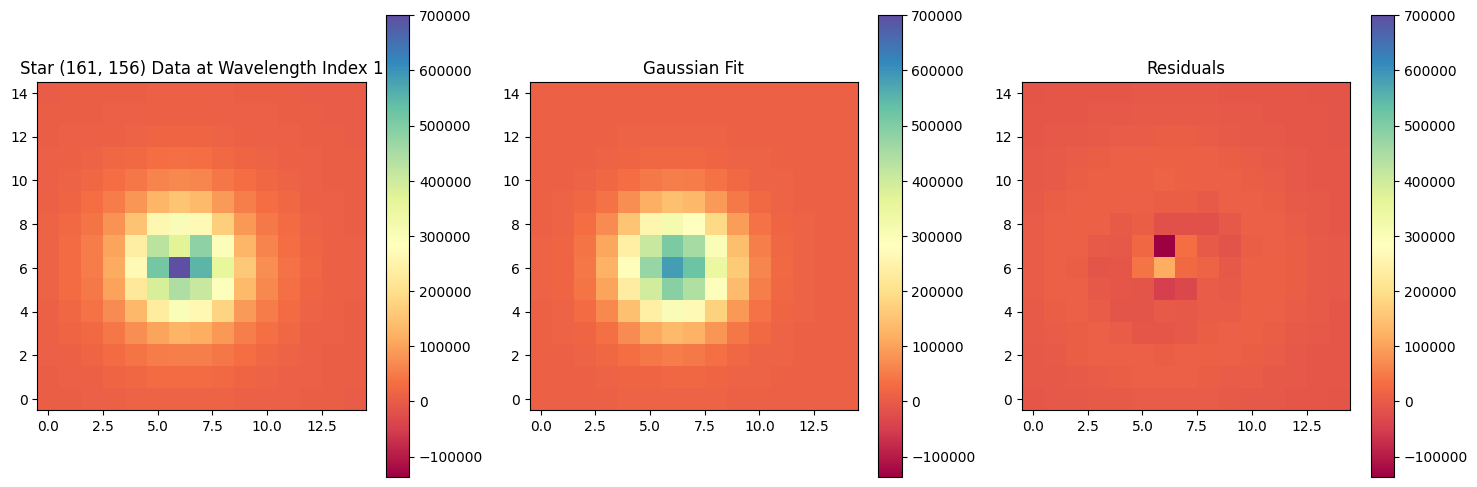

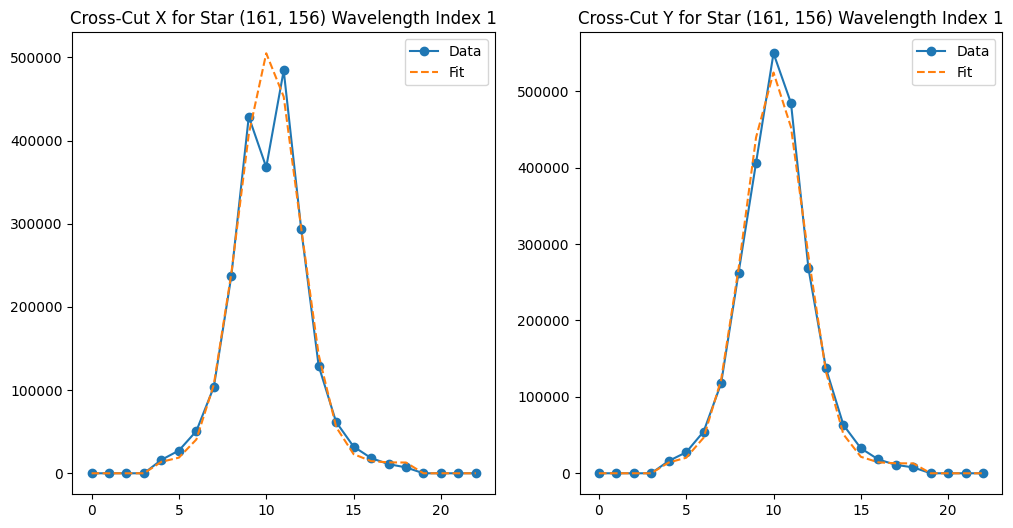

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3283.724609375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4797.64633
    reduced chi-square = 21.8074833
    Akaike info crit   = 698.450573
    Bayesian info crit = 715.531075
[[Variables]]
    x0:      6.15770178 +/- 0.02115246 (0.34%) (init = 6)
    y0:      6.04453952 +/- 0.02115246 (0.35%) (init = 6)
    sigma:   1.72734854 +/- 0.01671427 (0.97%) (init = 1)
    height:  578432.839 +/- 7083.09513 (1.22%) (init = 707794.9)
    offset:  12760.3209 +/- 1251.40043 (9.81%) (init = 17027.33)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6325
    C(sigma, offset) = -0.4463
{'x0': 6.157701782555364, 'y0': 6.044539523764816, 'sigma': 1.727348542219338, 'height': 578432.8387728039, 'offset': 12760.320942595348}
Chi-squared: 4797.64632754699

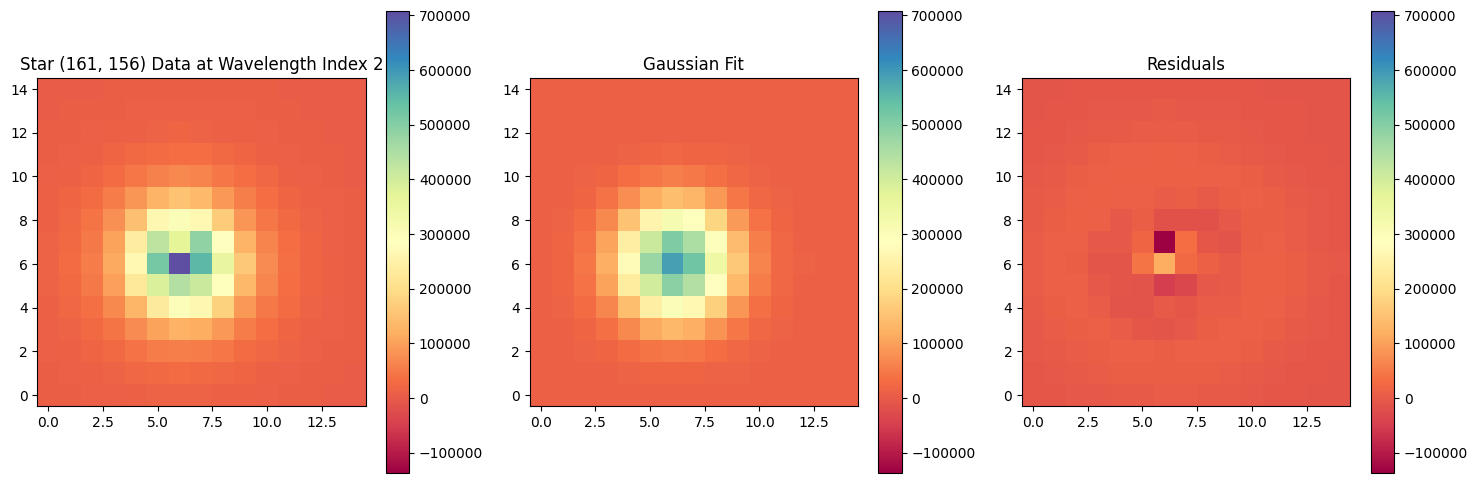

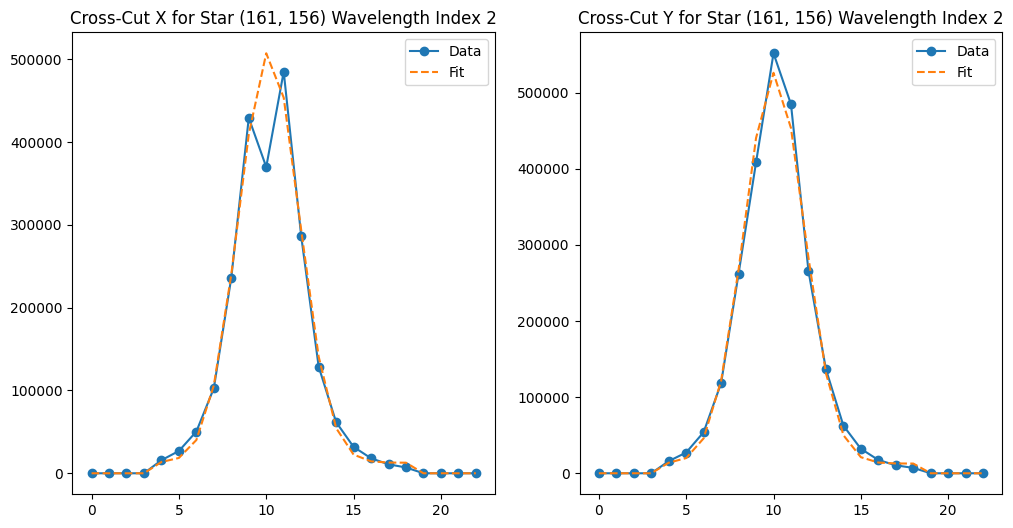

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3277.022705078125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4680.24345
    reduced chi-square = 21.2738339
    Akaike info crit   = 692.876126
    Bayesian info crit = 709.956628
[[Variables]]
    x0:      6.15797006 +/- 0.02083827 (0.34%) (init = 6)
    y0:      6.04220125 +/- 0.02083827 (0.34%) (init = 6)
    sigma:   1.72715647 +/- 0.01646545 (0.95%) (init = 1)
    height:  578741.991 +/- 6982.39204 (1.21%) (init = 705359.9)
    offset:  12741.8062 +/- 1233.40261 (9.68%) (init = 17101.59)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6325
    C(sigma, offset) = -0.4463
{'x0': 6.157970060391232, 'y0': 6.042201250271832, 'sigma': 1.7271564667361898, 'height': 578741.990821805, 'offset': 12741.806159358544}
Chi-squared: 4680.24344711

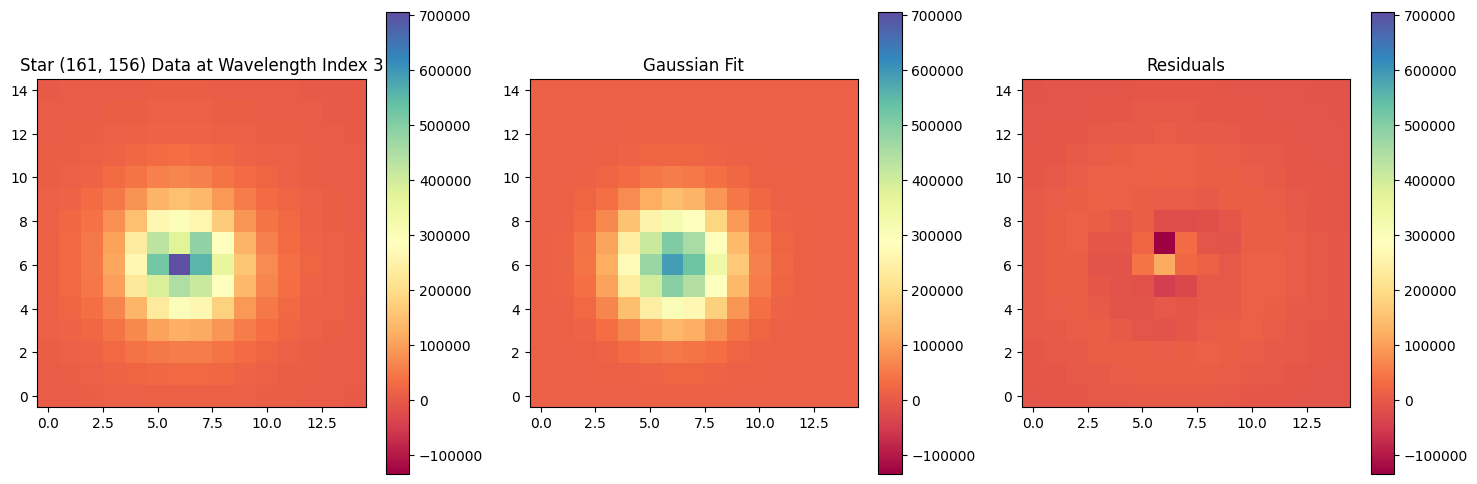

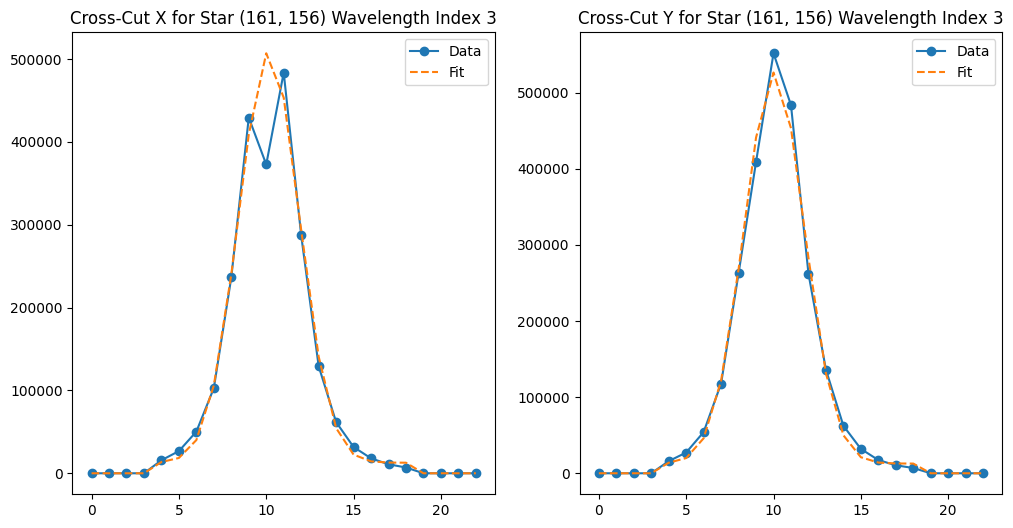

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3249.27734375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4796.63497
    reduced chi-square = 21.8028862
    Akaike info crit   = 698.403138
    Bayesian info crit = 715.483640
[[Variables]]
    x0:      6.15651443 +/- 0.02117617 (0.34%) (init = 6)
    y0:      6.04010297 +/- 0.02117617 (0.35%) (init = 6)
    sigma:   1.73220393 +/- 0.01674673 (0.97%) (init = 1)
    height:  571664.704 +/- 6988.39849 (1.22%) (init = 691379.7)
    offset:  12576.0476 +/- 1239.85424 (9.86%) (init = 17000.79)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6320
    C(sigma, offset) = -0.4478
{'x0': 6.156514434272248, 'y0': 6.040102966709082, 'sigma': 1.7322039269122278, 'height': 571664.7035298838, 'offset': 12576.047592943865}
Chi-squared: 4796.63497030103

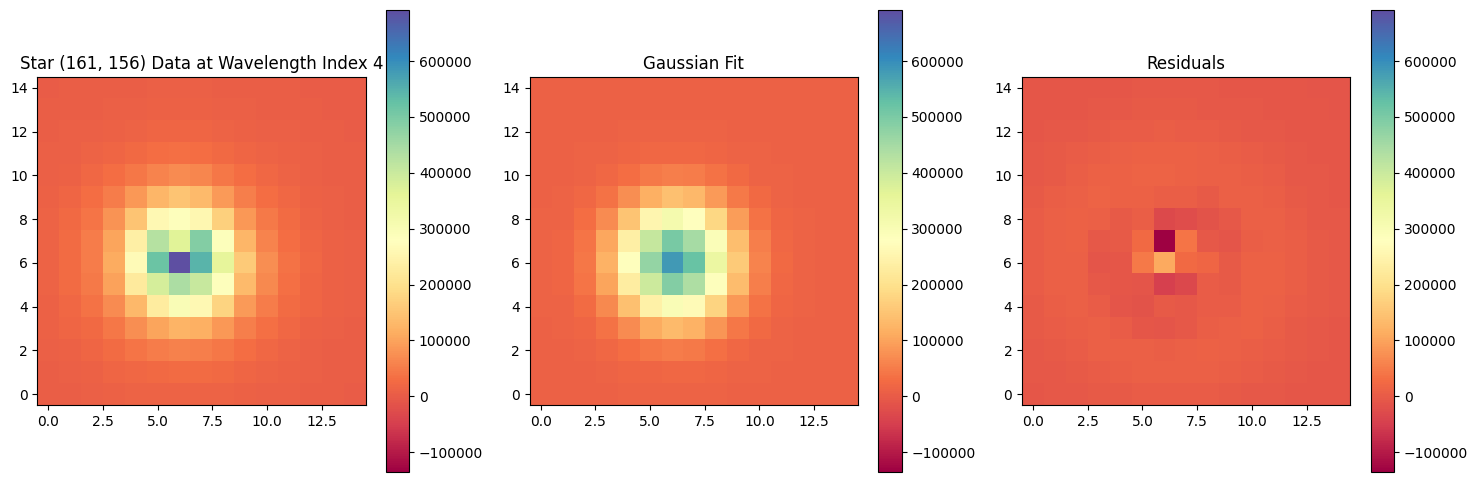

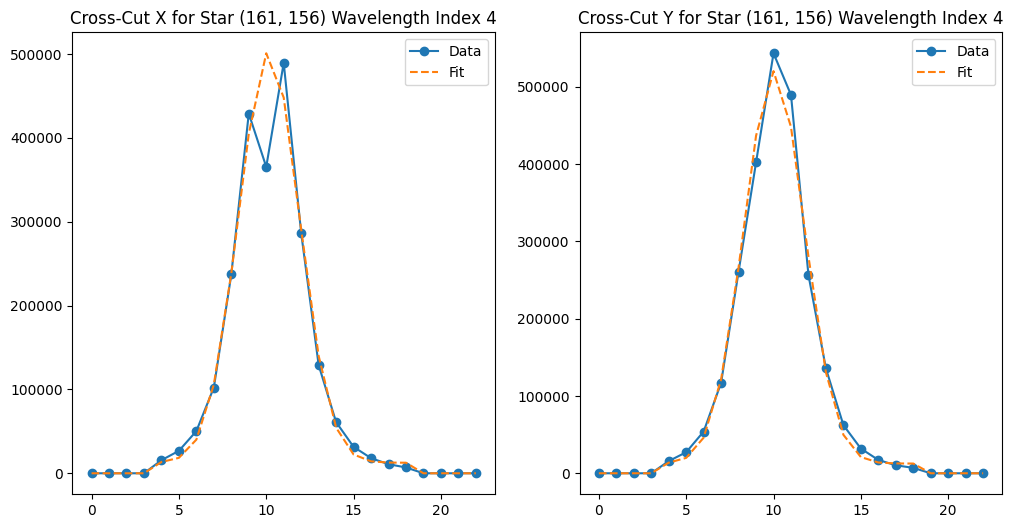

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3239.559814453125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4905.70197
    reduced chi-square = 22.2986453
    Akaike info crit   = 703.461941
    Bayesian info crit = 720.542443
[[Variables]]
    x0:      6.15554367 +/- 0.02142577 (0.35%) (init = 6)
    y0:      6.04797422 +/- 0.02142577 (0.35%) (init = 6)
    sigma:   1.73251835 +/- 0.01694509 (0.98%) (init = 1)
    height:  569683.947 +/- 7044.98541 (1.24%) (init = 690879.4)
    offset:  12425.5144 +/- 1250.23912 (10.06%) (init = 16834.26)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6319
    C(sigma, offset) = -0.4479
{'x0': 6.155543666829092, 'y0': 6.047974222758274, 'sigma': 1.732518346466198, 'height': 569683.946622416, 'offset': 12425.514402920358}
Chi-squared: 4905.70197234

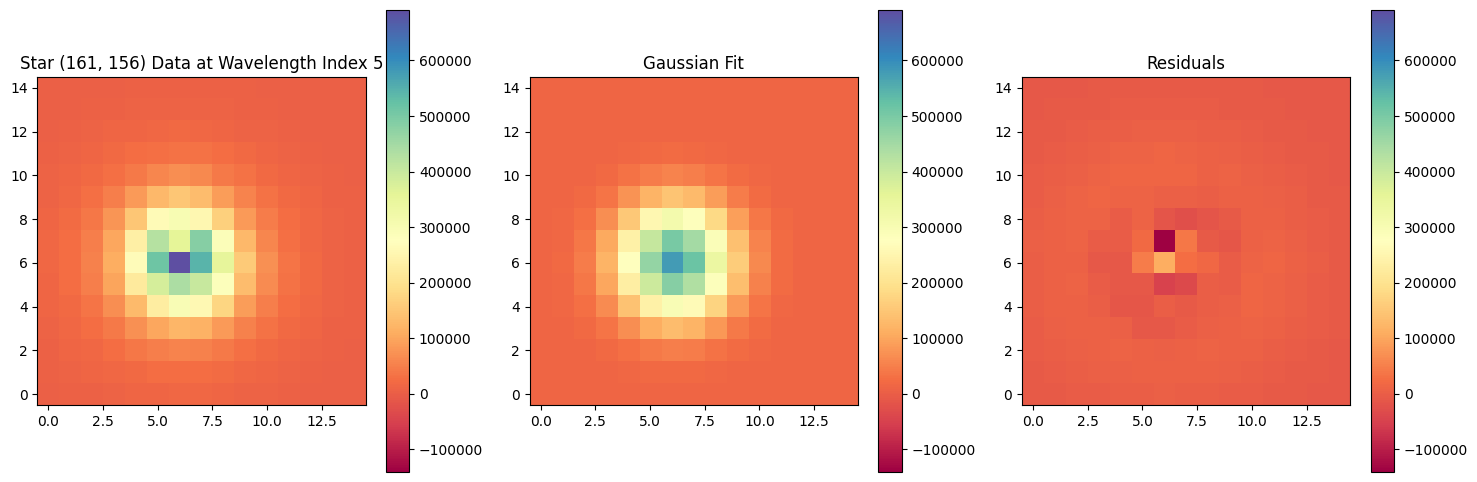

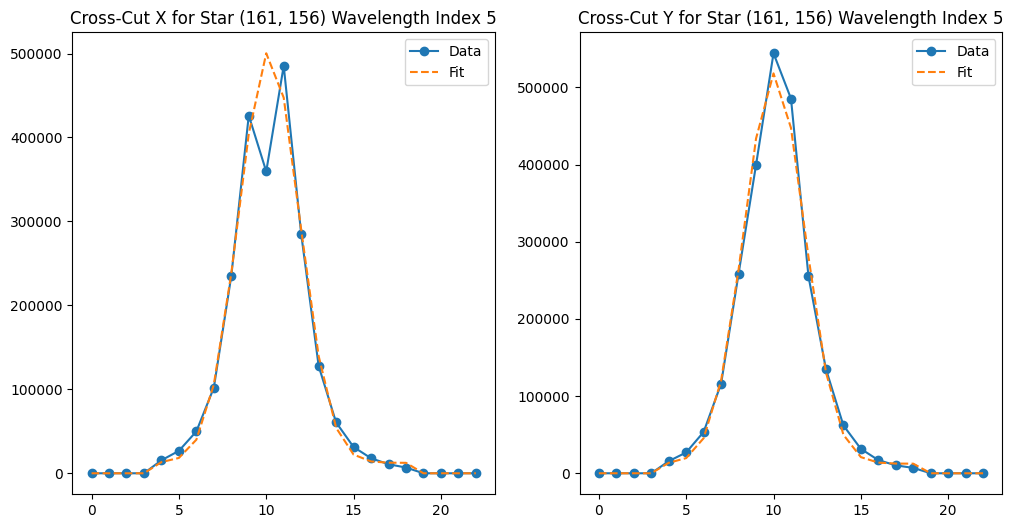

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3206.146240234375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4738.23701
    reduced chi-square = 21.5374409
    Akaike info crit   = 695.647001
    Bayesian info crit = 712.727503
[[Variables]]
    x0:      6.15249088 +/- 0.02107539 (0.34%) (init = 6)
    y0:      6.04805566 +/- 0.02107539 (0.35%) (init = 6)
    sigma:   1.74035784 +/- 0.01669030 (0.96%) (init = 1)
    height:  563313.561 +/- 6821.41036 (1.21%) (init = 676952.1)
    offset:  12259.3851 +/- 1218.77914 (9.94%) (init = 16722.88)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6310
    C(sigma, offset) = -0.4503
{'x0': 6.152490884699653, 'y0': 6.048055655306015, 'sigma': 1.7403578358169032, 'height': 563313.5608716526, 'offset': 12259.385099454956}
Chi-squared: 4738.2370084

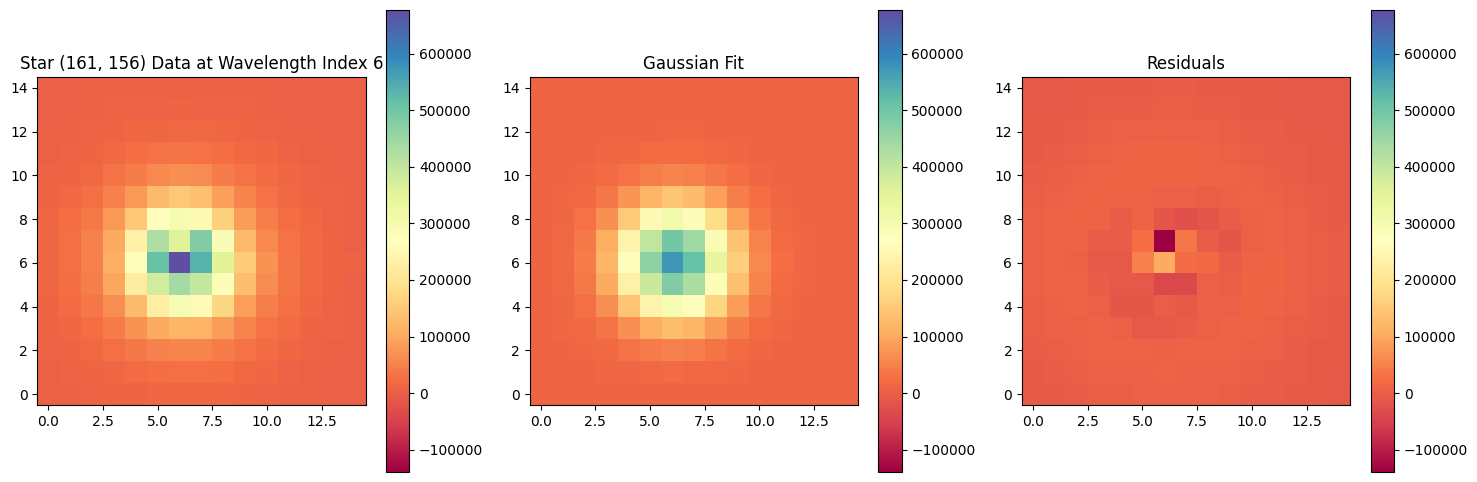

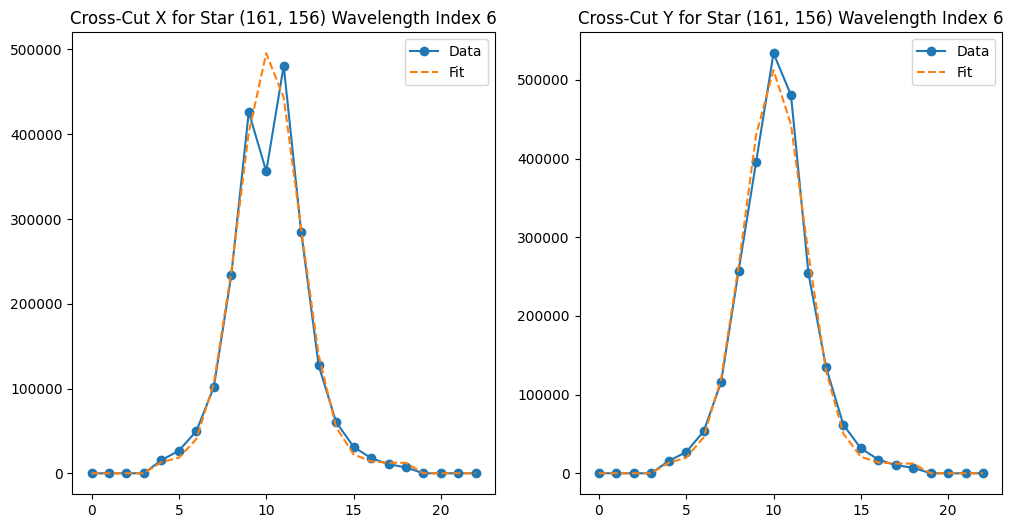

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3206.58349609375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4558.81484
    reduced chi-square = 20.7218856
    Akaike info crit   = 686.961452
    Bayesian info crit = 704.041954
[[Variables]]
    x0:      6.15143559 +/- 0.02069073 (0.34%) (init = 6)
    y0:      6.05986942 +/- 0.02069073 (0.34%) (init = 6)
    sigma:   1.73568724 +/- 0.01637268 (0.94%) (init = 1)
    height:  562894.041 +/- 6709.93307 (1.19%) (init = 680078.4)
    offset:  12296.6494 +/- 1194.04718 (9.71%) (init = 16702.46)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6316
    C(sigma, offset) = -0.4489
{'x0': 6.15143558607046, 'y0': 6.059869419666327, 'sigma': 1.7356872425065122, 'height': 562894.041448725, 'offset': 12296.649379541459}
Chi-squared: 4558.8148388341

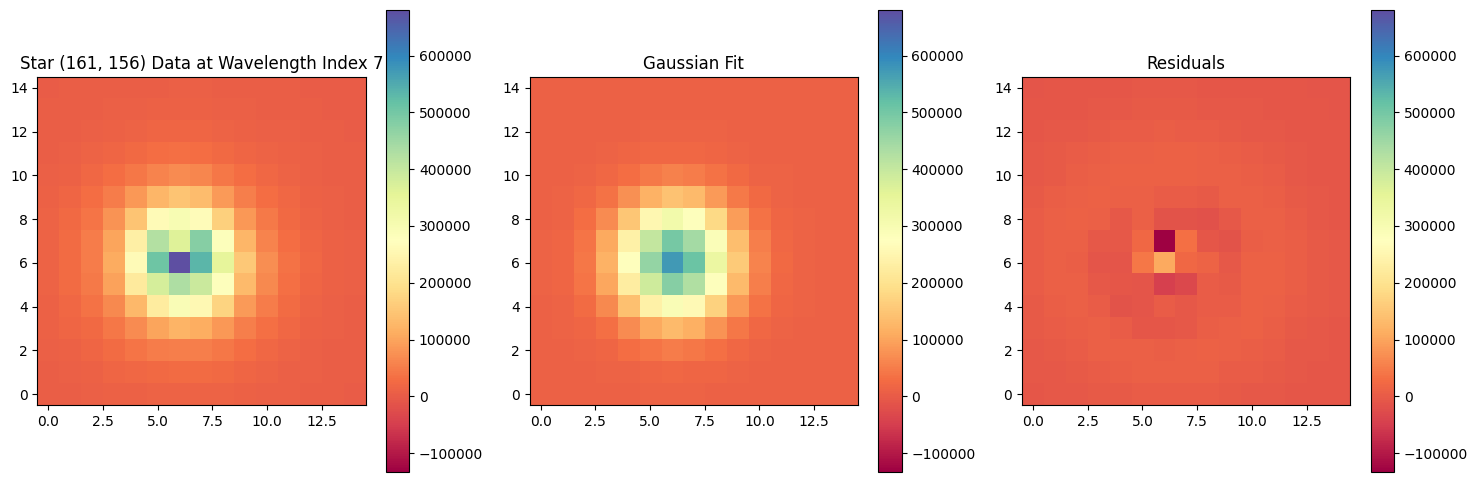

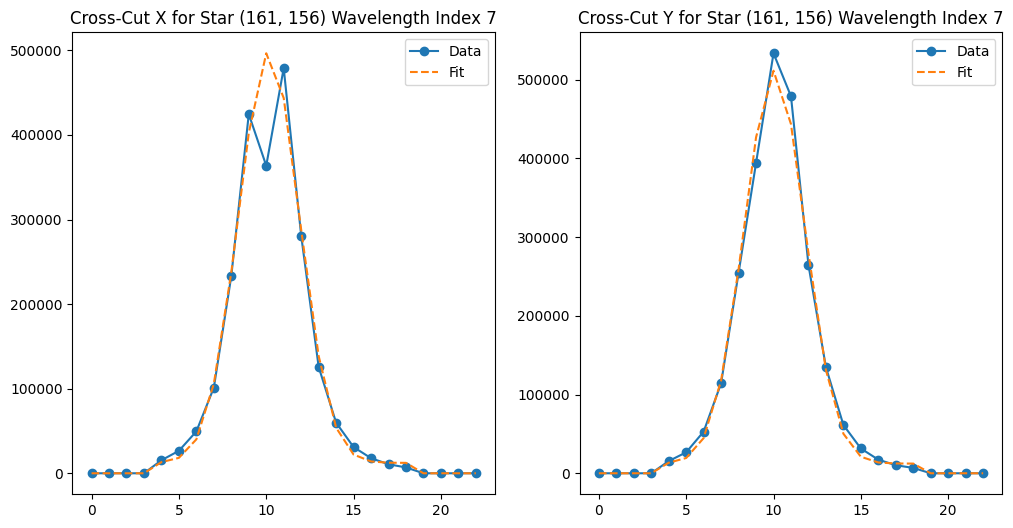

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3122.11572265625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4632.24301
    reduced chi-square = 21.0556501
    Akaike info crit   = 690.556618
    Bayesian info crit = 707.637120
[[Variables]]
    x0:      6.15408811 +/- 0.02093707 (0.34%) (init = 6)
    y0:      6.06183295 +/- 0.02093707 (0.35%) (init = 6)
    sigma:   1.73718521 +/- 0.01657189 (0.95%) (init = 1)
    height:  545962.405 +/- 6579.90476 (1.21%) (init = 662761.8)
    offset:  12542.2638 +/- 1172.42621 (9.35%) (init = 16946.91)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4493
{'x0': 6.154088109399104, 'y0': 6.061832948606717, 'sigma': 1.7371852132366519, 'height': 545962.4054475825, 'offset': 12542.263781949014}
Chi-squared: 4632.24301132

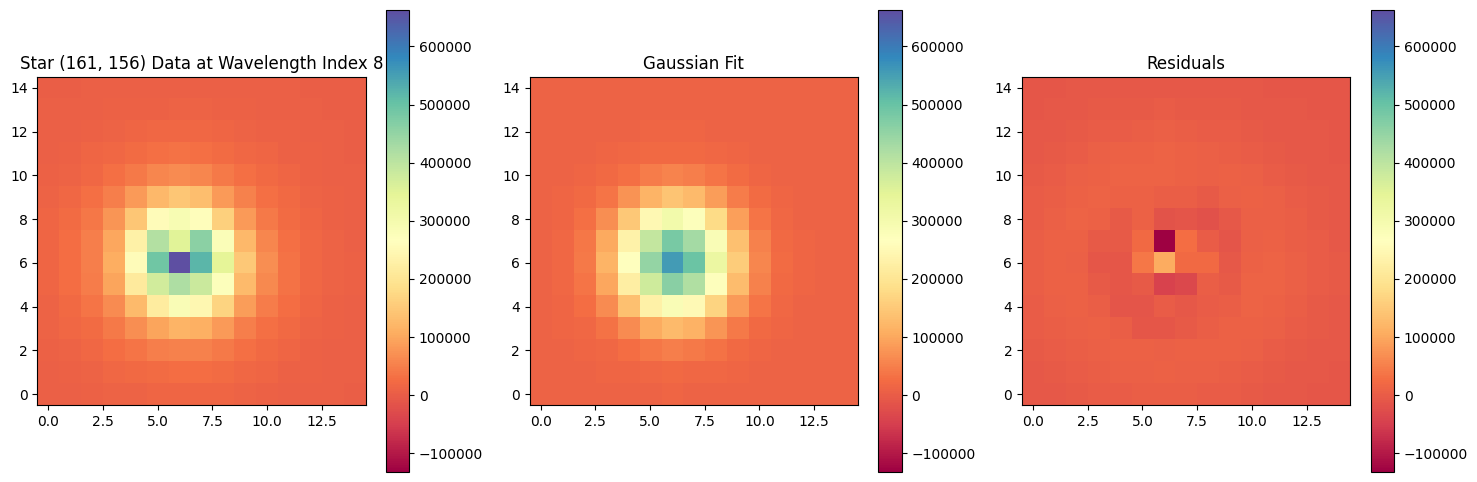

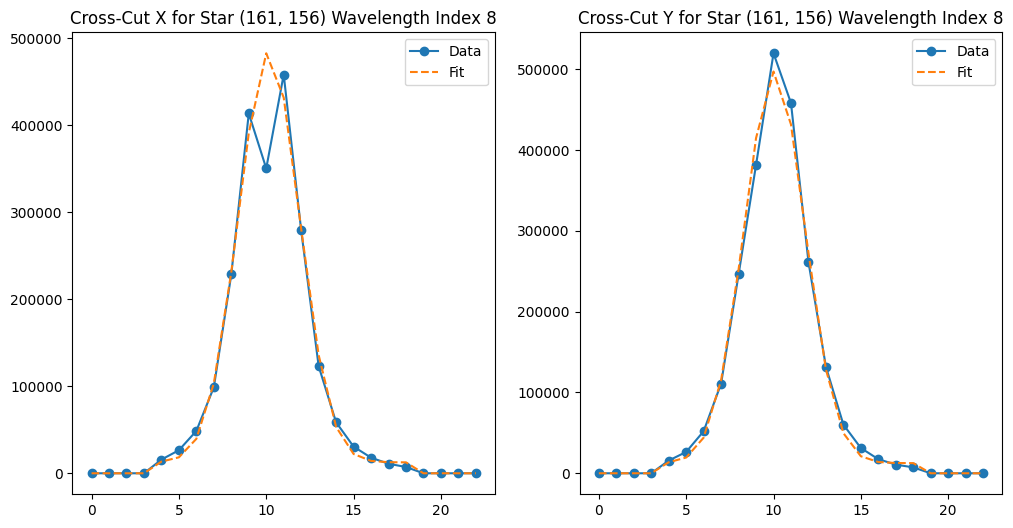

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3047.355224609375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 225
    # variables        = 5
    chi-square         = 3793.60852
    reduced chi-square = 17.2436751
    Akaike info crit   = 645.618826
    Bayesian info crit = 662.699328
[[Variables]]
    x0:      6.15844611 +/- 0.01899891 (0.31%) (init = 6)
    y0:      6.06341365 +/- 0.01899891 (0.31%) (init = 6)
    sigma:   1.73051205 +/- 0.01502073 (0.87%) (init = 1)
    height:  531434.905 +/- 5834.46992 (1.10%) (init = 645163.2)
    offset:  13442.0543 +/- 1033.61504 (7.69%) (init = 17737.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6321
    C(sigma, offset) = -0.4473
{'x0': 6.158446111442789, 'y0': 6.063413649561901, 'sigma': 1.7305120489911356, 'height': 531434.9048065036, 'offset': 13442.054276555024}
Chi-squared: 3793.60851662

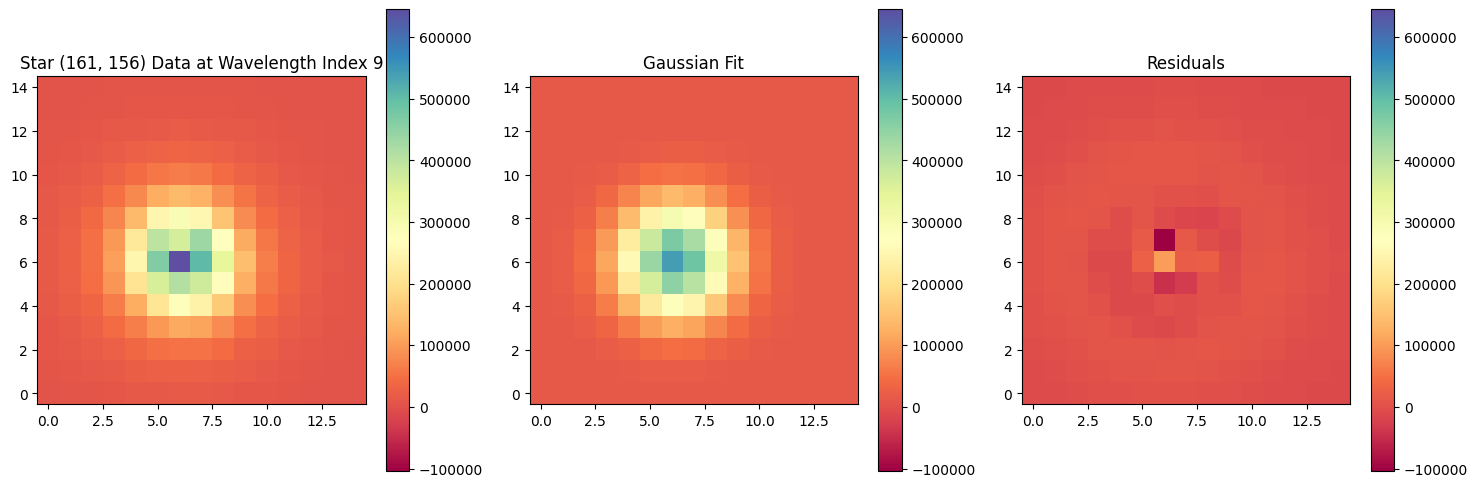

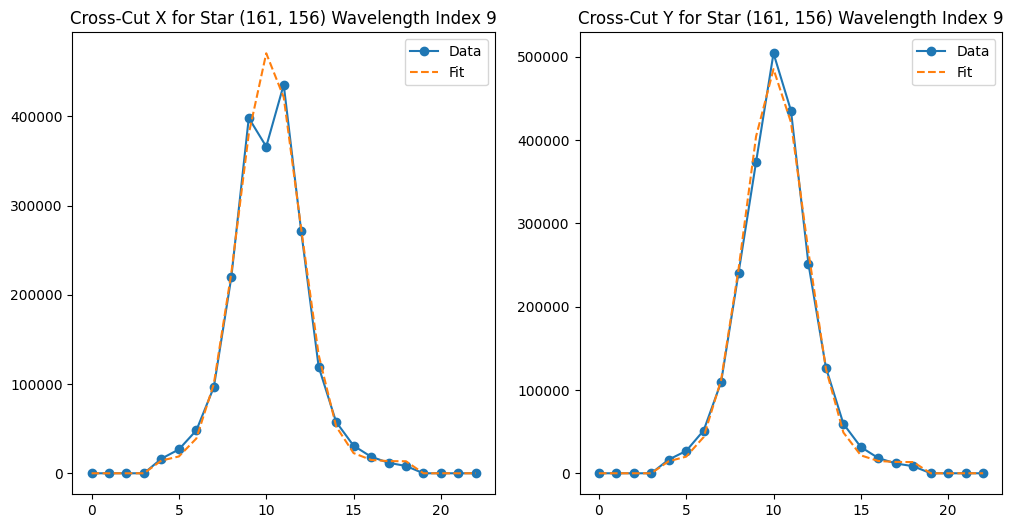

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3047.721435546875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4215.50565
    reduced chi-square = 19.1613893
    Akaike info crit   = 669.345496
    Bayesian info crit = 686.425998
[[Variables]]
    x0:      6.16101205 +/- 0.01967874 (0.32%) (init = 6)
    y0:      6.04296467 +/- 0.01967874 (0.33%) (init = 6)
    sigma:   1.72238099 +/- 0.01553677 (0.90%) (init = 1)
    height:  540923.479 +/- 6180.06562 (1.14%) (init = 659099.4)
    offset:  13485.4529 +/- 1087.18605 (8.06%) (init = 17547.82)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6330
    C(sigma, offset) = -0.4448
{'x0': 6.161012050494937, 'y0': 6.042964666791449, 'sigma': 1.7223809883446737, 'height': 540923.4793939883, 'offset': 13485.452886552152}
Chi-squared: 4215.5056505

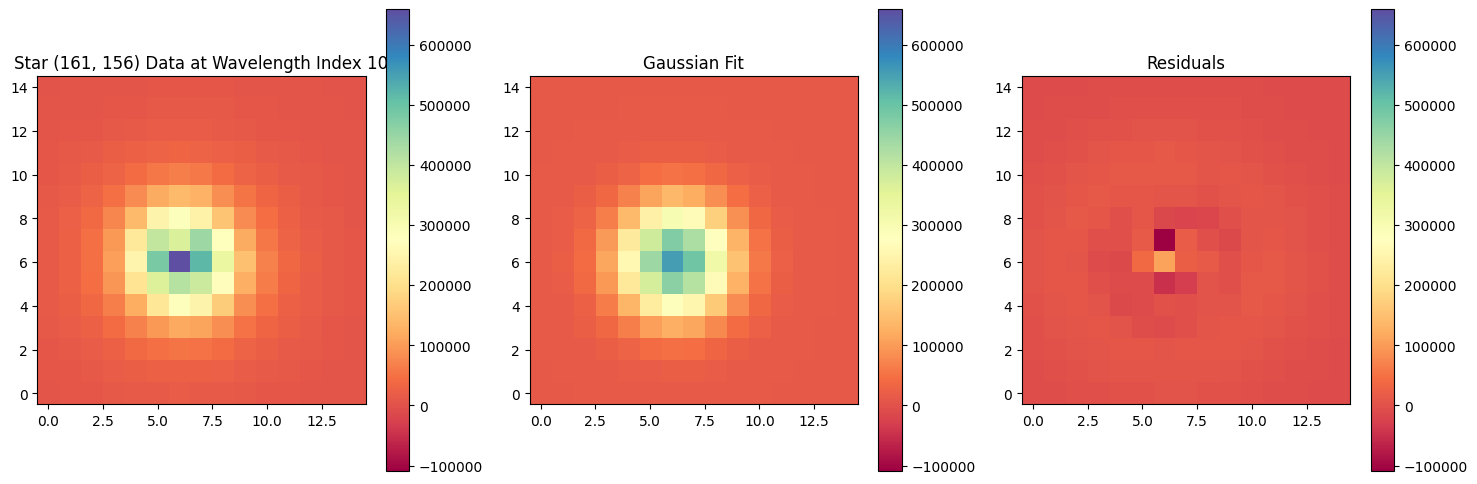

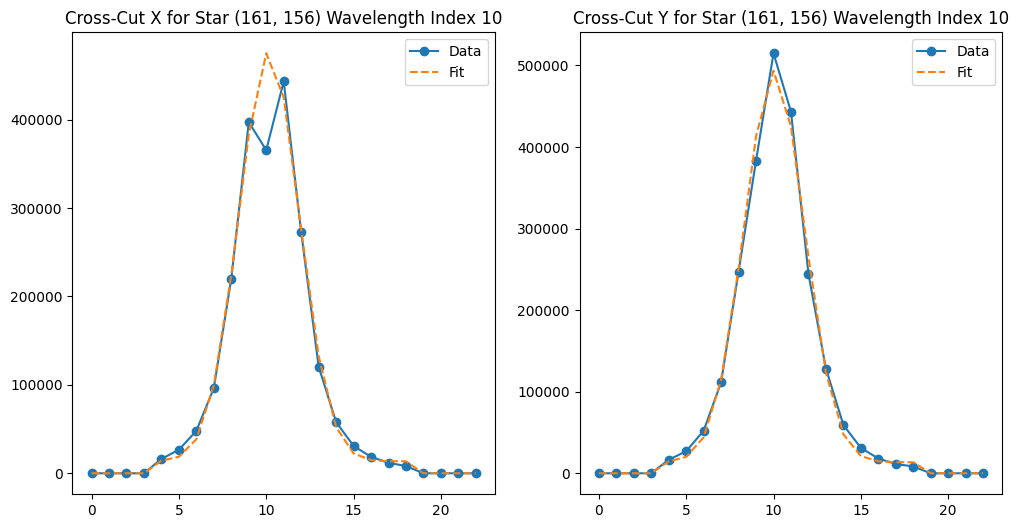

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3130.674560546875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4778.94246
    reduced chi-square = 21.7224657
    Akaike info crit   = 697.571685
    Bayesian info crit = 714.652187
[[Variables]]
    x0:      6.15733434 +/- 0.02100136 (0.34%) (init = 6)
    y0:      6.04206462 +/- 0.02100137 (0.35%) (init = 6)
    sigma:   1.73342790 +/- 0.01661196 (0.96%) (init = 1)
    height:  554357.415 +/- 6716.14005 (1.21%) (init = 676051.8)
    offset:  12512.2459 +/- 1192.81190 (9.53%) (init = 16835.56)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6318
    C(sigma, offset) = -0.4482
{'x0': 6.1573343417209845, 'y0': 6.04206462231171, 'sigma': 1.7334279010755933, 'height': 554357.4145557566, 'offset': 12512.245870708215}
Chi-squared: 4778.9424609

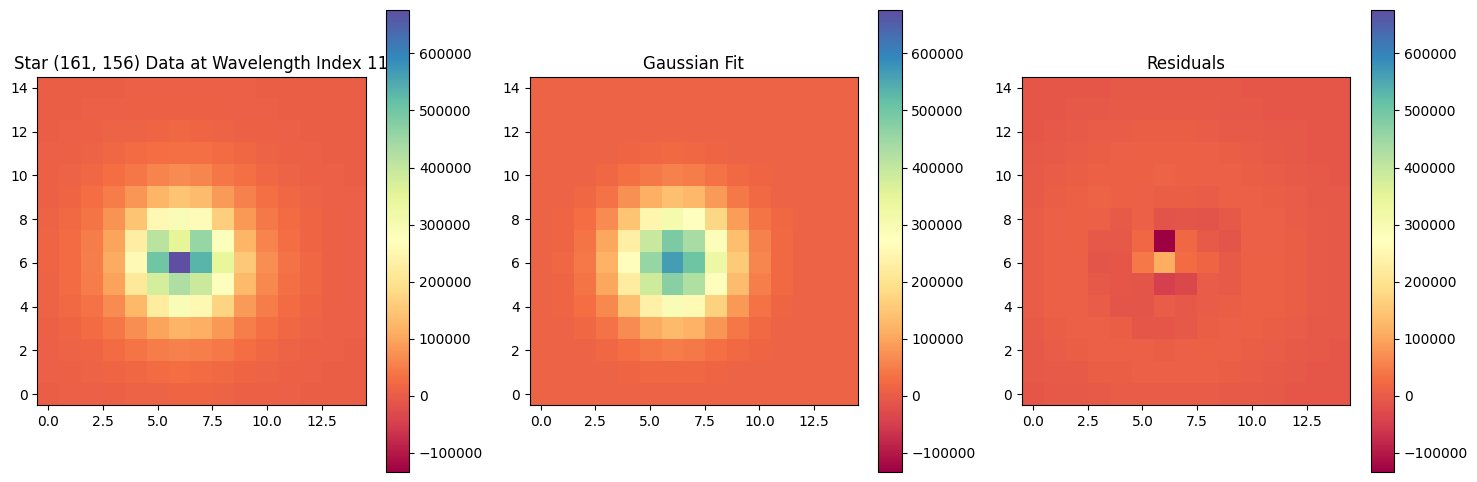

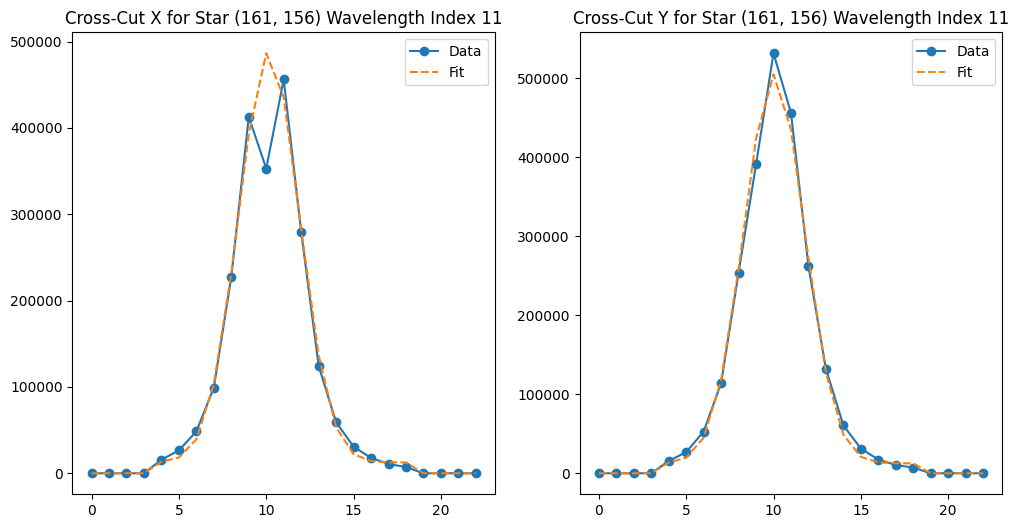

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3175.47705078125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4781.05485
    reduced chi-square = 21.7320675
    Akaike info crit   = 697.671118
    Bayesian info crit = 714.751620
[[Variables]]
    x0:      6.15648313 +/- 0.02111013 (0.34%) (init = 6)
    y0:      6.04434465 +/- 0.02111013 (0.35%) (init = 6)
    sigma:   1.73738436 +/- 0.01670929 (0.96%) (init = 1)
    height:  559517.754 +/- 6798.23534 (1.22%) (init = 677551.6)
    offset:  12203.6618 +/- 1211.52476 (9.93%) (init = 16611.67)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4494
{'x0': 6.156483133591765, 'y0': 6.044344651548319, 'sigma': 1.7373843581498607, 'height': 559517.754274629, 'offset': 12203.661783264037}
Chi-squared: 4781.054854685

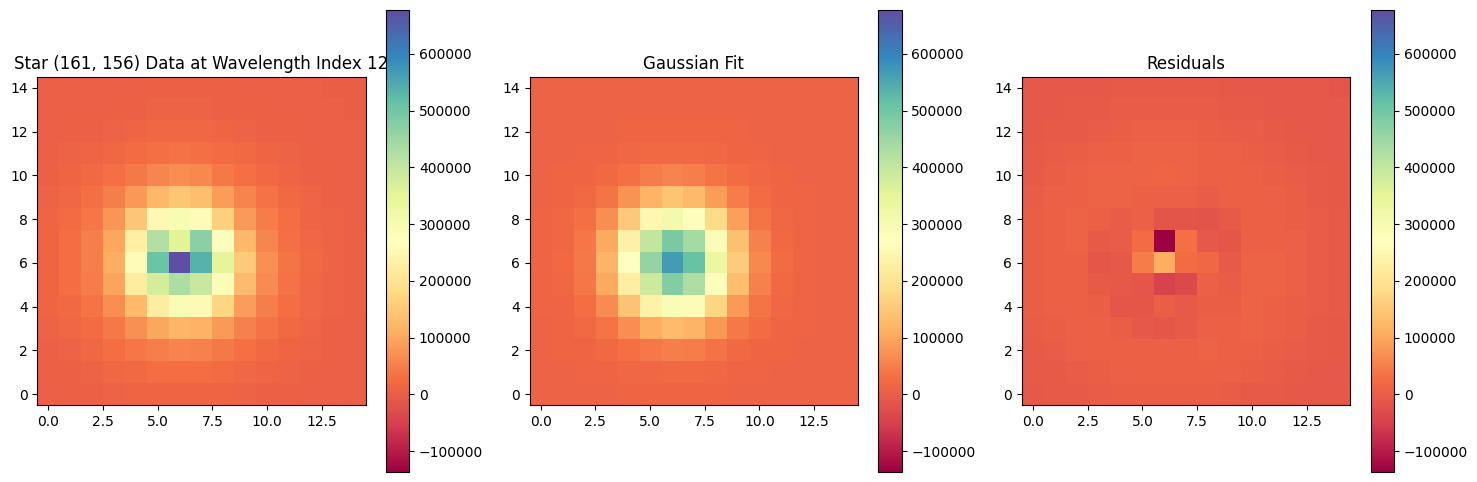

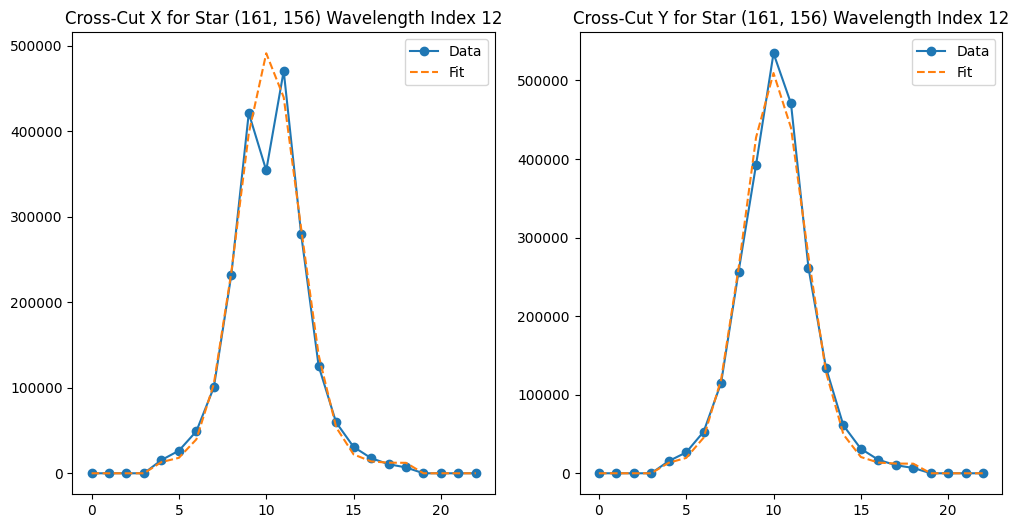

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3174.92919921875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5023.13209
    reduced chi-square = 22.8324186
    Akaike info crit   = 708.784421
    Bayesian info crit = 725.864923
[[Variables]]
    x0:      6.16290995 +/- 0.02168252 (0.35%) (init = 6)
    y0:      6.03580394 +/- 0.02168252 (0.36%) (init = 6)
    sigma:   1.73699832 +/- 0.01716118 (0.99%) (init = 1)
    height:  558271.350 +/- 6968.56584 (1.25%) (init = 678316.8)
    offset:  12188.2499 +/- 1241.46243 (10.19%) (init = 16609.91)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4493
{'x0': 6.1629099528045925, 'y0': 6.035803943108534, 'sigma': 1.7369983243998268, 'height': 558271.3500629284, 'offset': 12188.249906809577}
Chi-squared: 5023.132090

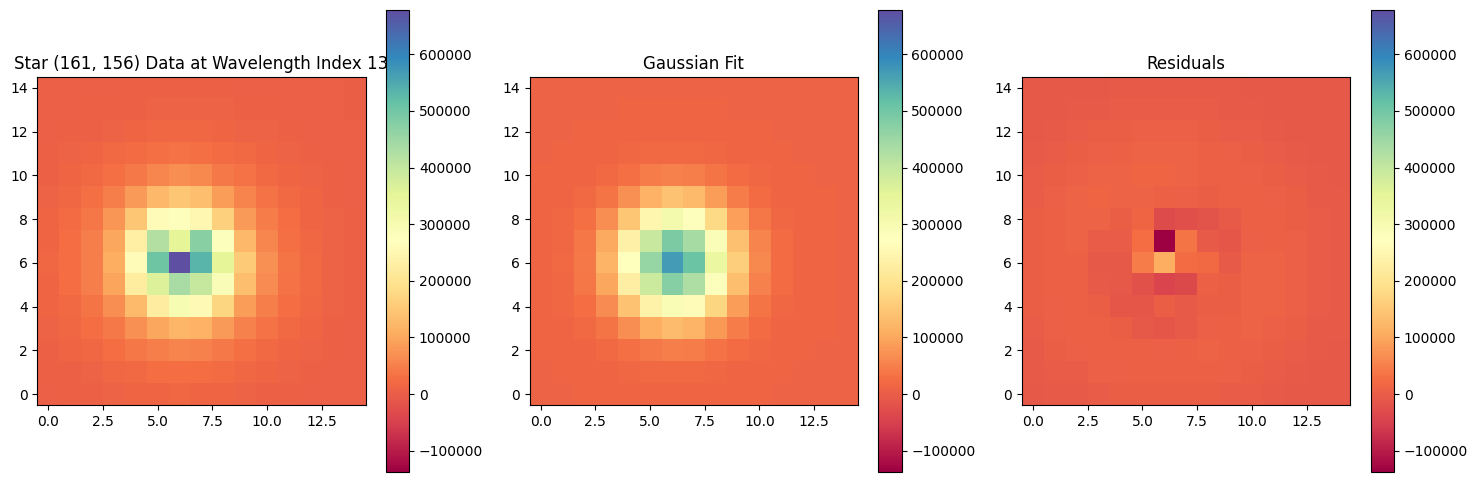

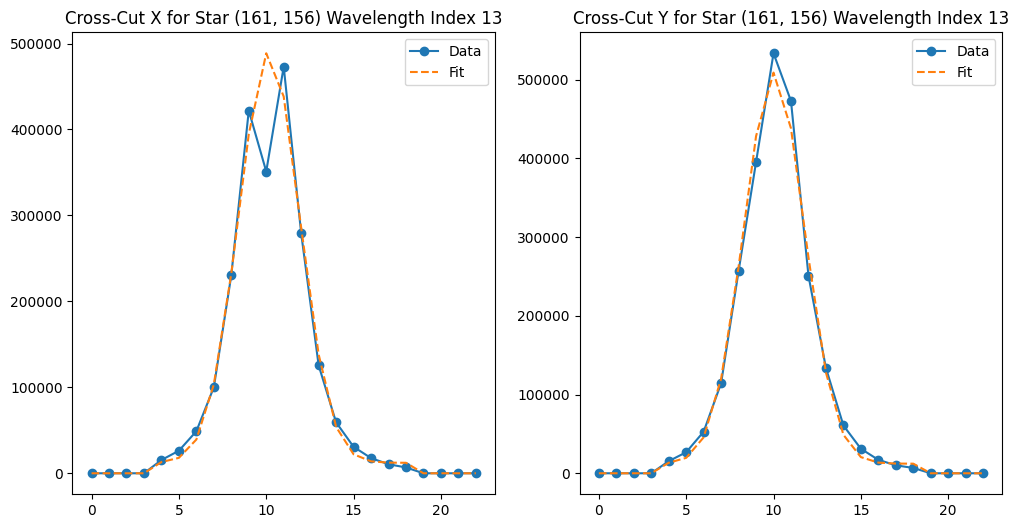

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3178.978515625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4926.06103
    reduced chi-square = 22.3911865
    Akaike info crit   = 704.393777
    Bayesian info crit = 721.474279
[[Variables]]
    x0:      6.16638734 +/- 0.02139510 (0.35%) (init = 6)
    y0:      6.04410169 +/- 0.02139510 (0.35%) (init = 6)
    sigma:   1.73630158 +/- 0.01693179 (0.98%) (init = 1)
    height:  560992.312 +/- 6912.47736 (1.23%) (init = 683964.2)
    offset:  12119.3816 +/- 1230.73878 (10.16%) (init = 16524.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6315
    C(sigma, offset) = -0.4491
{'x0': 6.1663873401527445, 'y0': 6.04410168515546, 'sigma': 1.7363015751128268, 'height': 560992.3124601179, 'offset': 12119.38164624531}
Chi-squared: 4926.0610296557

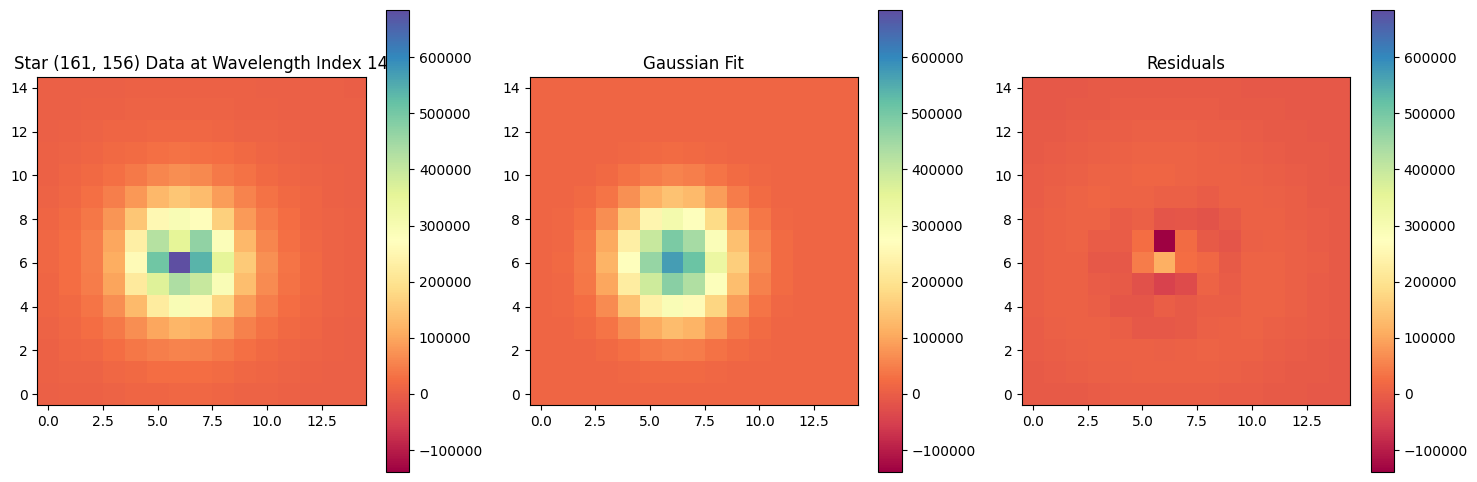

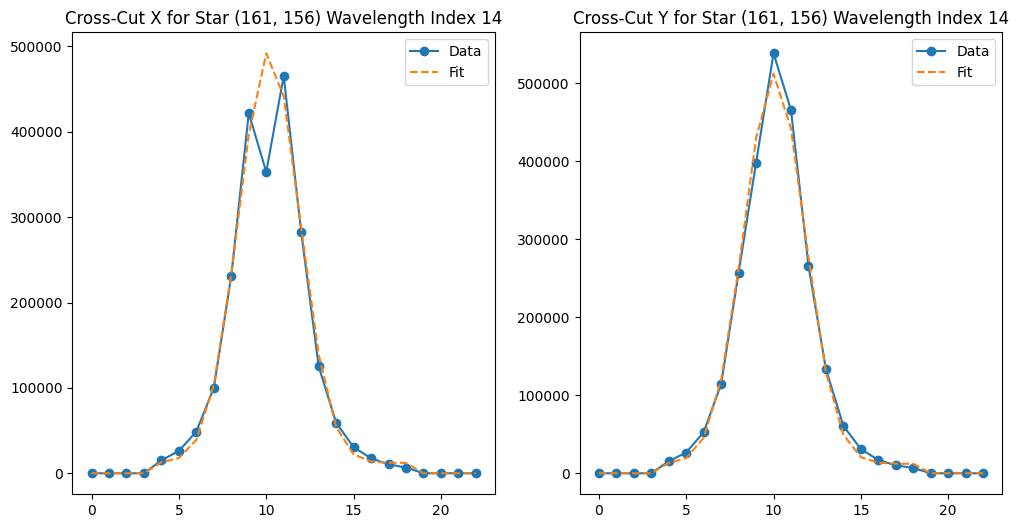

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3178.13232421875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5079.03804
    reduced chi-square = 23.0865365
    Akaike info crit   = 711.274771
    Bayesian info crit = 728.355273
[[Variables]]
    x0:      6.16418478 +/- 0.02173778 (0.35%) (init = 6)
    y0:      6.04274567 +/- 0.02173779 (0.36%) (init = 6)
    sigma:   1.73236366 +/- 0.01719142 (0.99%) (init = 1)
    height:  560506.986 +/- 7033.07477 (1.25%) (init = 684982)
    offset:  12199.5095 +/- 1247.95898 (10.23%) (init = 16537.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6319
    C(sigma, offset) = -0.4479
{'x0': 6.16418477858171, 'y0': 6.042745669339068, 'sigma': 1.7323636560009819, 'height': 560506.9858712348, 'offset': 12199.509495708351}
Chi-squared: 5079.0380405937

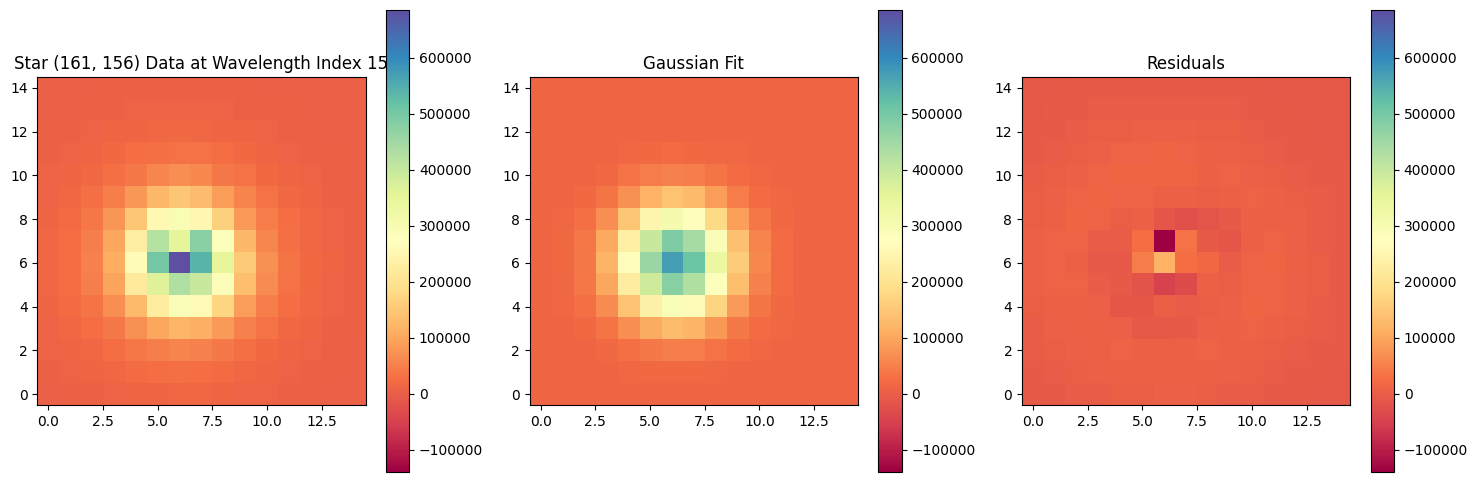

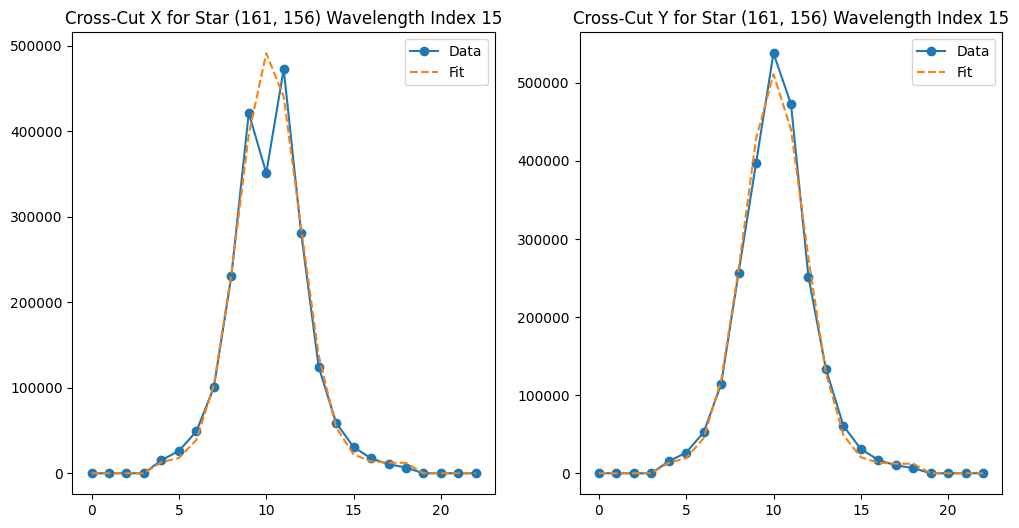

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3174.93603515625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5006.62103
    reduced chi-square = 22.7573683
    Akaike info crit   = 708.043627
    Bayesian info crit = 725.124129
[[Variables]]
    x0:      6.16214395 +/- 0.02163650 (0.35%) (init = 6)
    y0:      6.04208972 +/- 0.02163650 (0.36%) (init = 6)
    sigma:   1.73581843 +/- 0.01712136 (0.99%) (init = 1)
    height:  558539.609 +/- 6961.84979 (1.25%) (init = 679770.8)
    offset:  12102.4940 +/- 1239.00764 (10.24%) (init = 16513.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6316
    C(sigma, offset) = -0.4489
{'x0': 6.162143950016478, 'y0': 6.042089716452816, 'sigma': 1.7358184317956165, 'height': 558539.608605454, 'offset': 12102.49401145179}
Chi-squared: 5006.6210283152

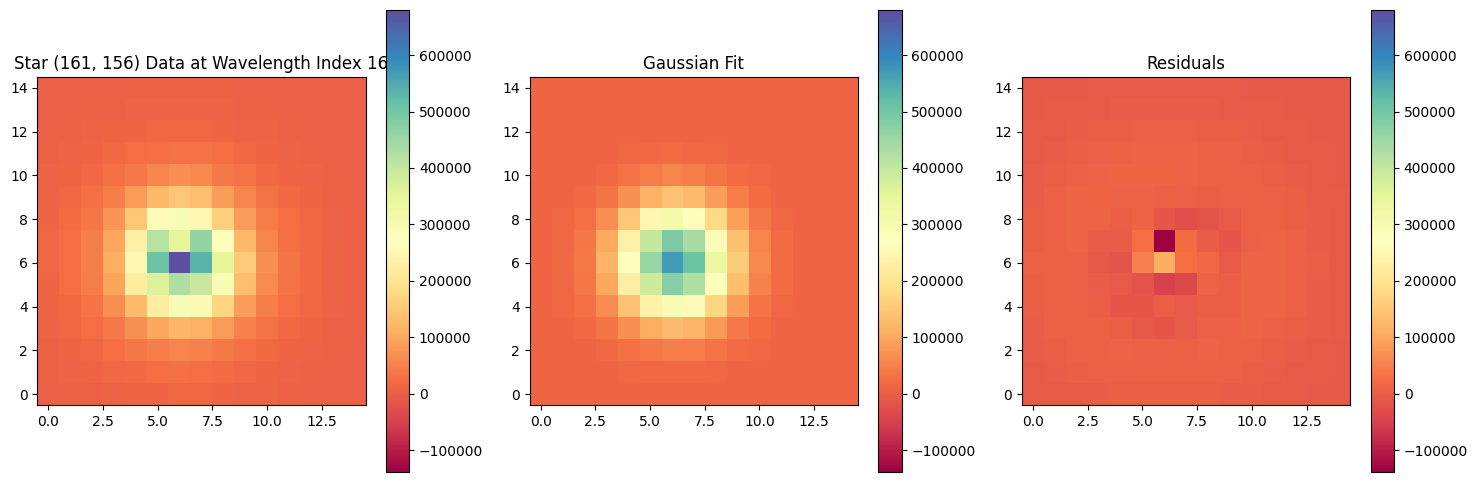

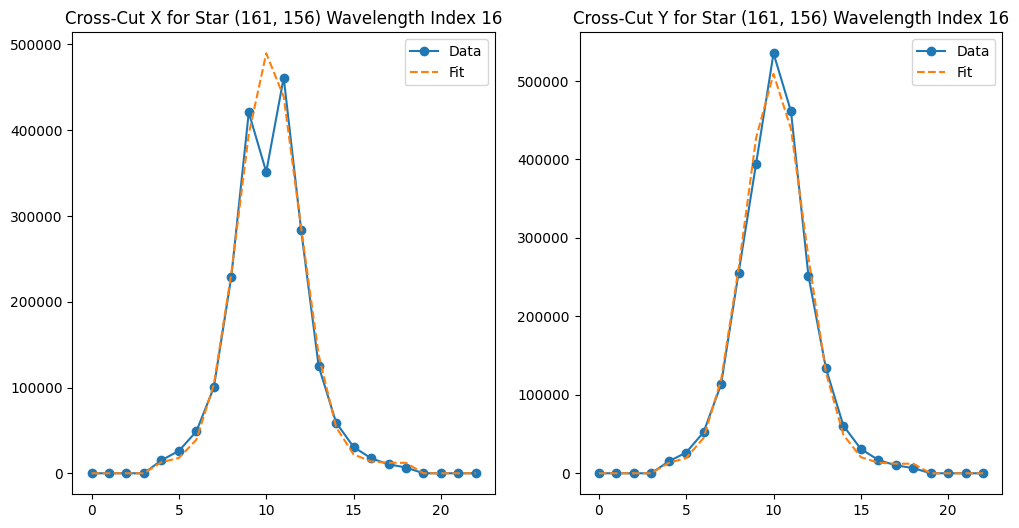

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3155.86083984375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5182.80135
    reduced chi-square = 23.5581879
    Akaike info crit   = 715.825132
    Bayesian info crit = 732.905634
[[Variables]]
    x0:      6.15893271 +/- 0.02190795 (0.36%) (init = 6)
    y0:      6.03419501 +/- 0.02190795 (0.36%) (init = 6)
    sigma:   1.72995466 +/- 0.01731878 (1.00%) (init = 1)
    height:  557867.400 +/- 7064.60947 (1.27%) (init = 682179.4)
    offset:  12231.0825 +/- 1250.93627 (10.23%) (init = 16511.63)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6322
    C(sigma, offset) = -0.4471
{'x0': 6.158932712689823, 'y0': 6.034195007345734, 'sigma': 1.7299546631535798, 'height': 557867.4000638259, 'offset': 12231.082486363819}
Chi-squared: 5182.8013477

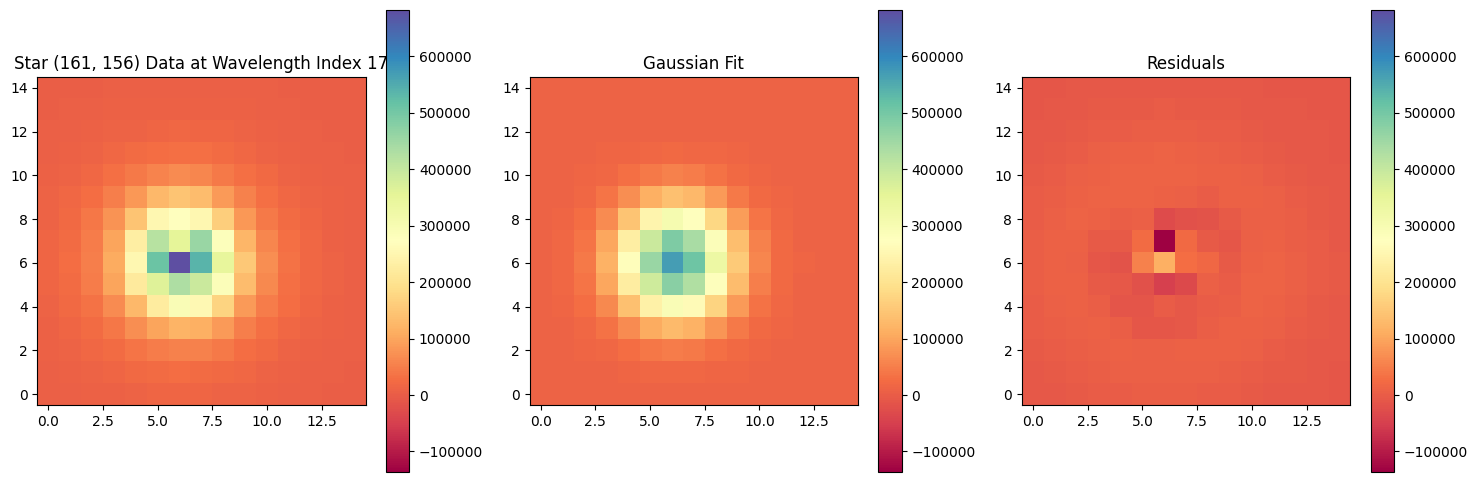

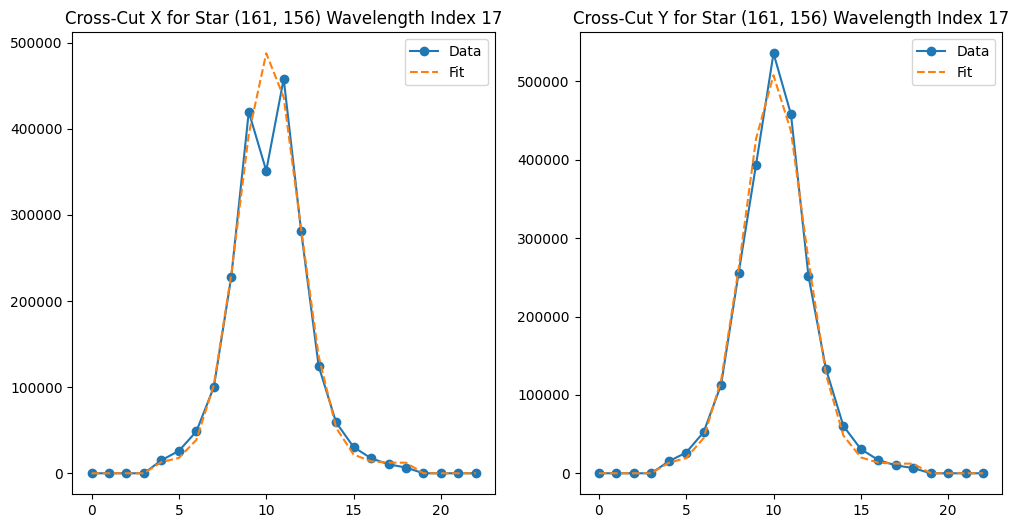

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3169.096435546875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4837.81398
    reduced chi-square = 21.9900635
    Akaike info crit   = 700.326514
    Bayesian info crit = 717.407016
[[Variables]]
    x0:      6.16559960 +/- 0.02144404 (0.35%) (init = 6)
    y0:      6.03826077 +/- 0.02144404 (0.36%) (init = 6)
    sigma:   1.73865995 +/- 0.01697730 (0.98%) (init = 1)
    height:  552951.553 +/- 6819.72629 (1.23%) (init = 680282)
    offset:  12037.7366 +/- 1216.69270 (10.11%) (init = 16393.86)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6312
    C(sigma, offset) = -0.4498
{'x0': 6.165599600242377, 'y0': 6.038260771462704, 'sigma': 1.7386599461237202, 'height': 552951.552765003, 'offset': 12037.736607371318}
Chi-squared: 4837.813980171

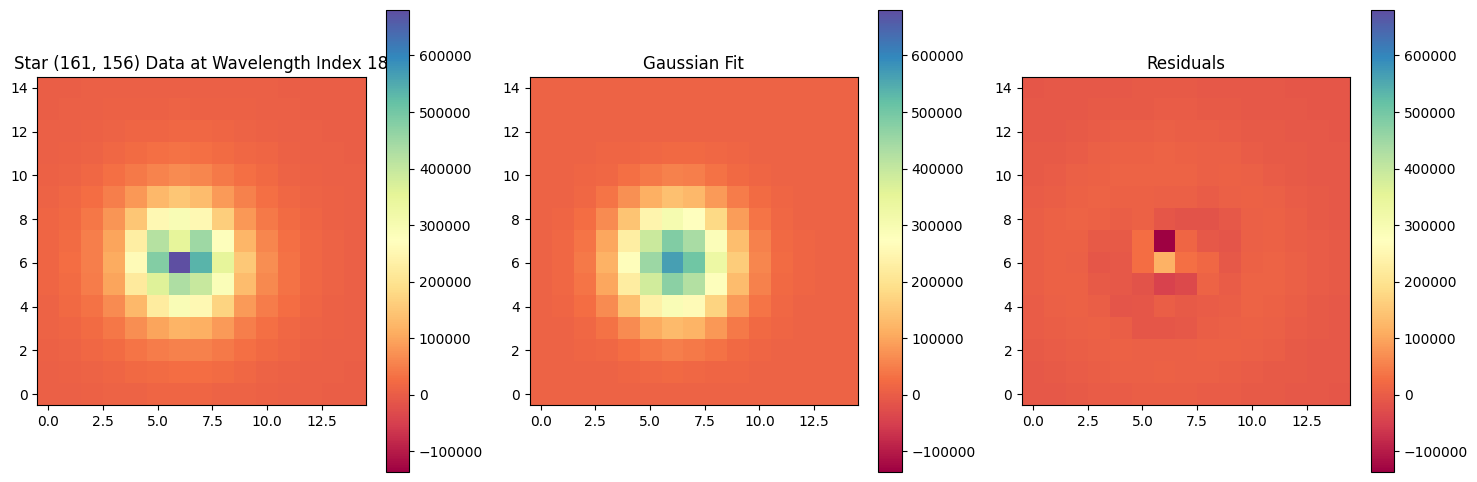

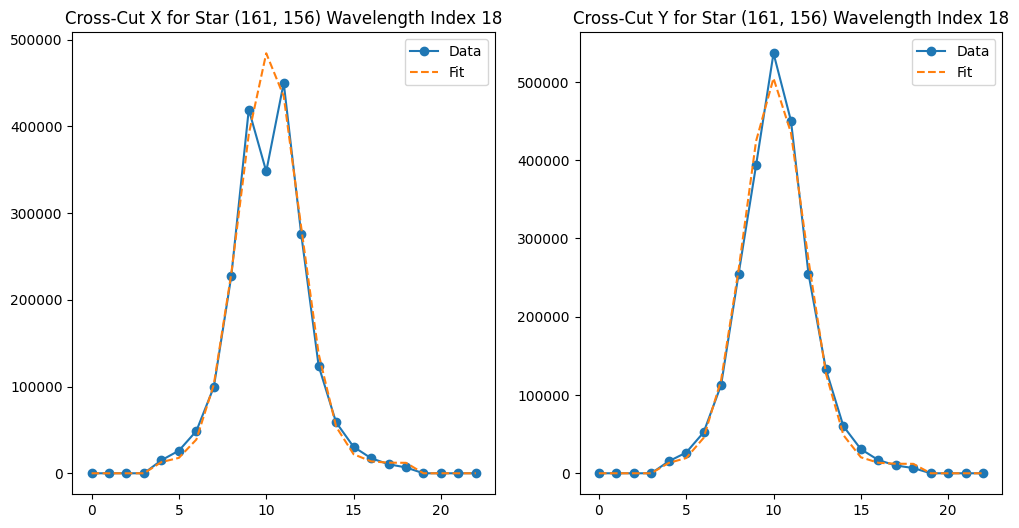

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3157.57763671875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4856.92074
    reduced chi-square = 22.0769125
    Akaike info crit   = 701.213393
    Bayesian info crit = 718.293895
[[Variables]]
    x0:      6.16325647 +/- 0.02148822 (0.35%) (init = 6)
    y0:      6.03999219 +/- 0.02148822 (0.36%) (init = 6)
    sigma:   1.74102691 +/- 0.01701919 (0.98%) (init = 1)
    height:  550894.007 +/- 6799.08248 (1.23%) (init = 674026.8)
    offset:  11971.3465 +/- 1215.49067 (10.15%) (init = 16453.36)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6310
    C(sigma, offset) = -0.4505
{'x0': 6.1632564725048224, 'y0': 6.039992187491223, 'sigma': 1.7410269053328045, 'height': 550894.0065469635, 'offset': 11971.346461651421}
Chi-squared: 4856.920744

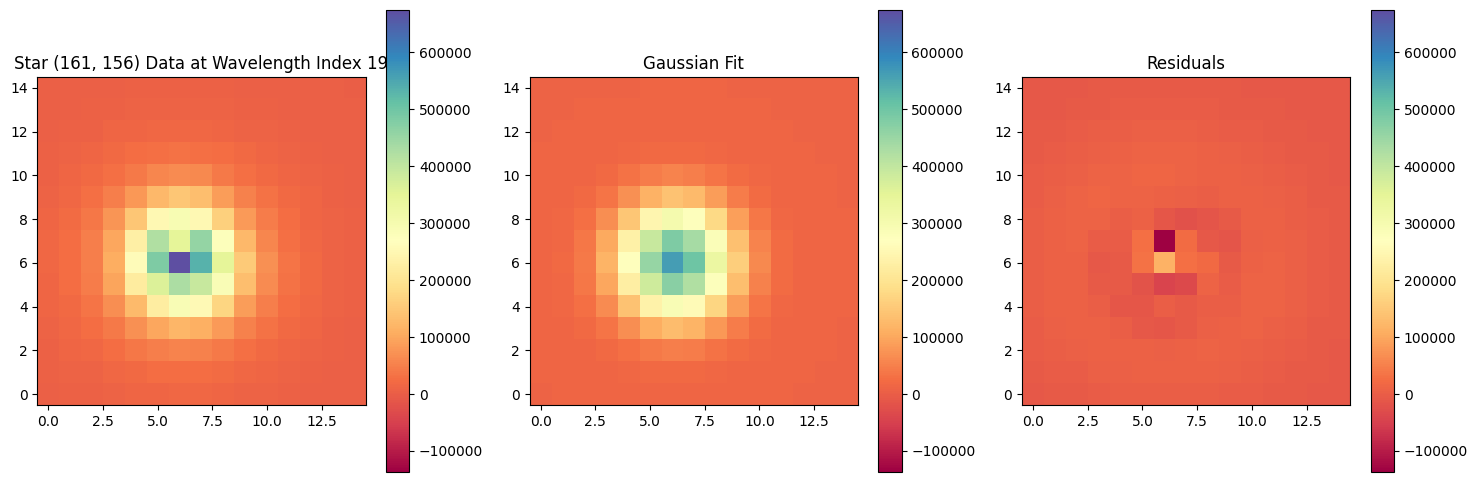

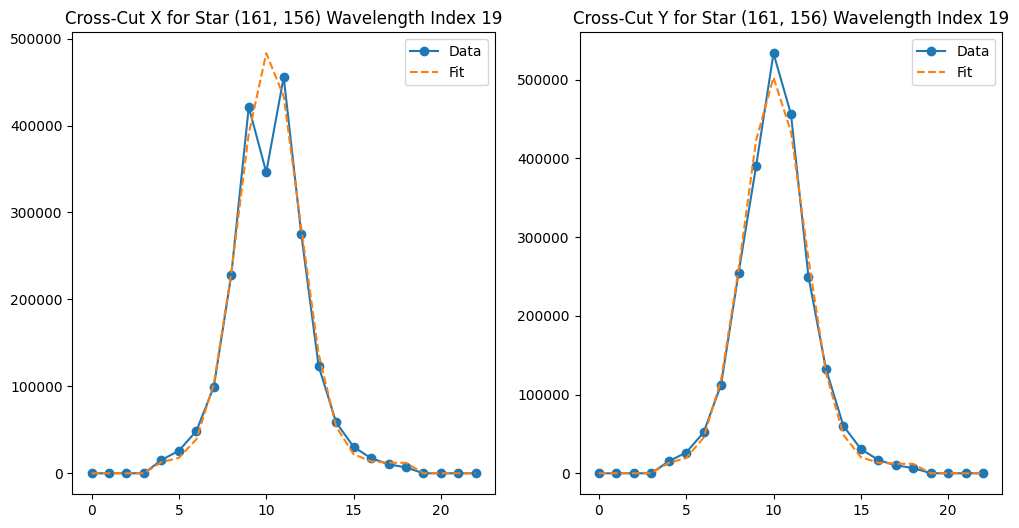

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3134.18115234375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5213.36730
    reduced chi-square = 23.6971241
    Akaike info crit   = 717.148189
    Bayesian info crit = 734.228691
[[Variables]]
    x0:      6.15836345 +/- 0.02207362 (0.36%) (init = 6)
    y0:      6.03686858 +/- 0.02207363 (0.37%) (init = 6)
    sigma:   1.73659662 +/- 0.01746950 (1.01%) (init = 1)
    height:  551496.791 +/- 7009.81018 (1.27%) (init = 671639.9)
    offset:  12003.1894 +/- 1248.37332 (10.40%) (init = 16418.93)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6315
    C(sigma, offset) = -0.4491
{'x0': 6.158363452678014, 'y0': 6.036868576446774, 'sigma': 1.7365966204758332, 'height': 551496.7908267039, 'offset': 12003.189416528927}
Chi-squared: 5213.3673048

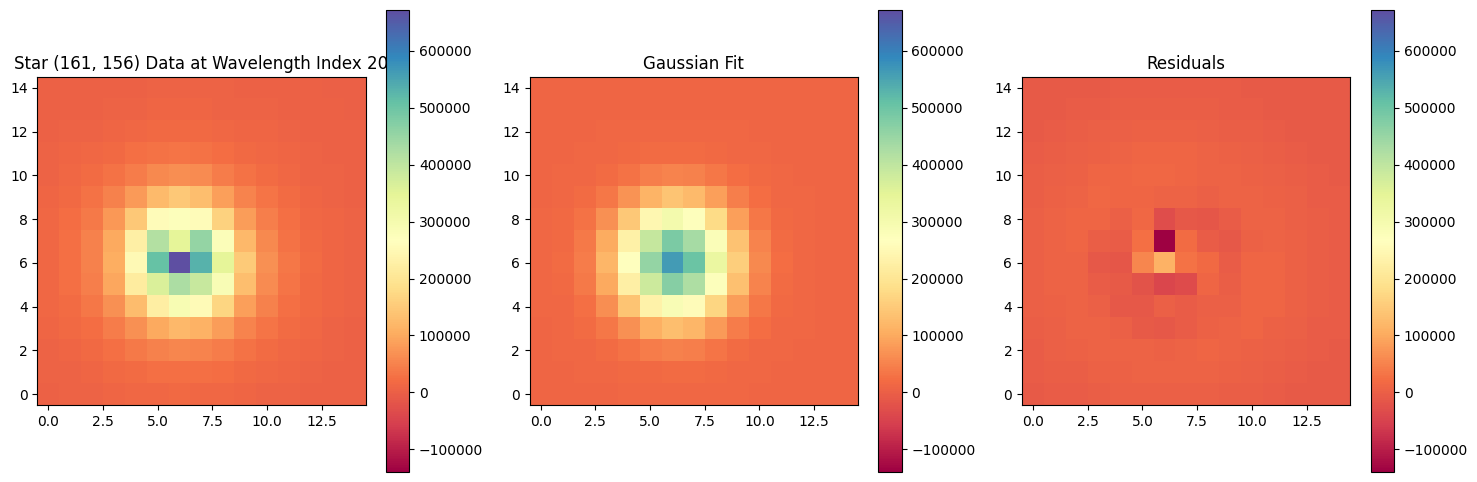

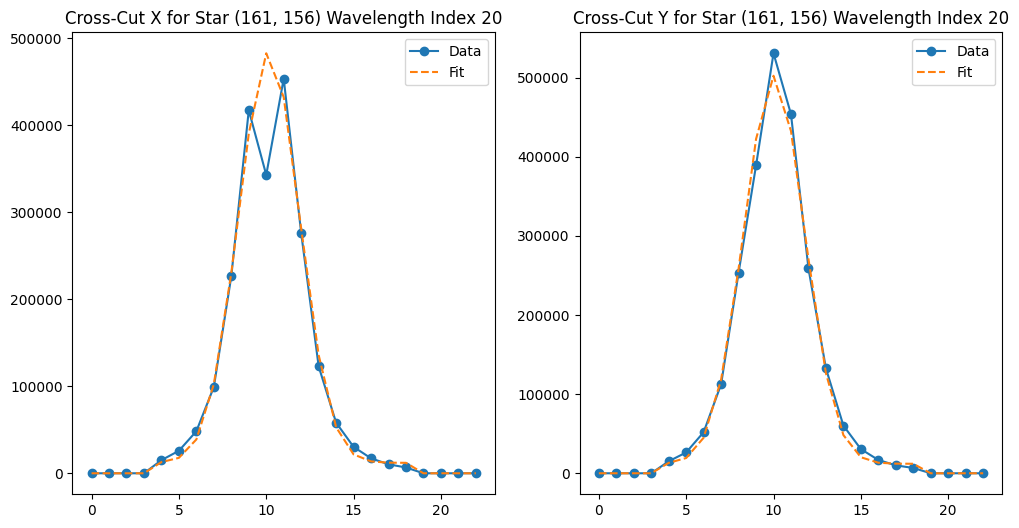

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3144.299560546875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5126.68883
    reduced chi-square = 23.3031310
    Akaike info crit   = 713.375847
    Bayesian info crit = 730.456349
[[Variables]]
    x0:      6.16546795 +/- 0.02192637 (0.36%) (init = 6)
    y0:      6.04390453 +/- 0.02192637 (0.36%) (init = 6)
    sigma:   1.73570888 +/- 0.01735046 (1.00%) (init = 1)
    height:  552343.276 +/- 6977.29829 (1.26%) (init = 683602.7)
    offset:  11939.9426 +/- 1241.64228 (10.40%) (init = 16278.67)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6316
    C(sigma, offset) = -0.4489
{'x0': 6.165467950680699, 'y0': 6.043904528495727, 'sigma': 1.7357088839529284, 'height': 552343.2756727897, 'offset': 11939.942616187984}
Chi-squared: 5126.688827

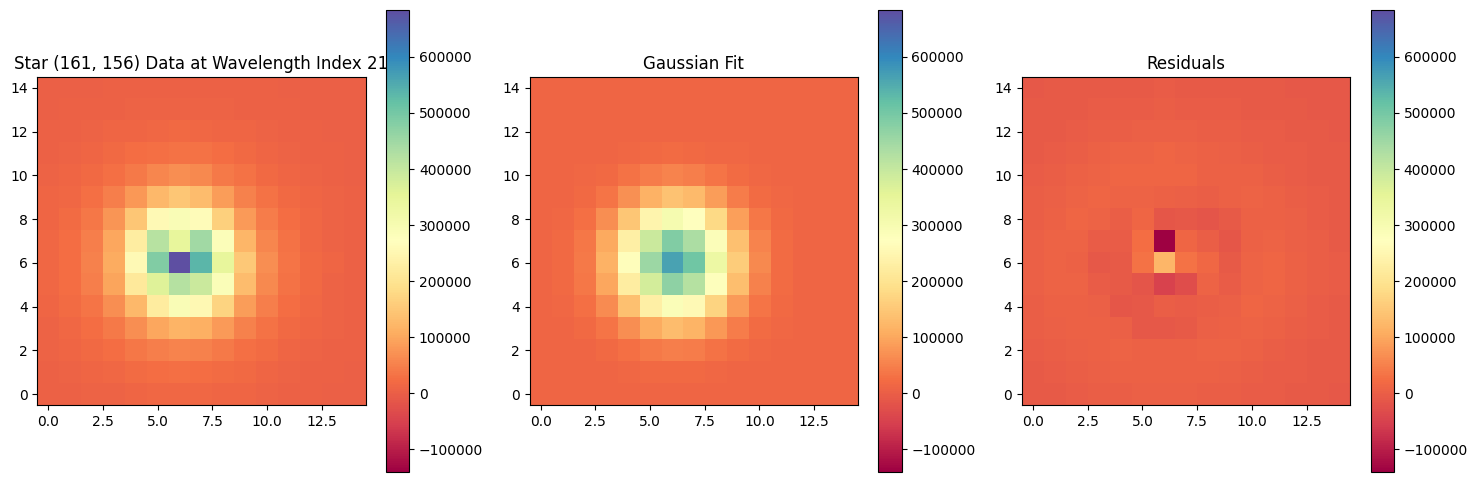

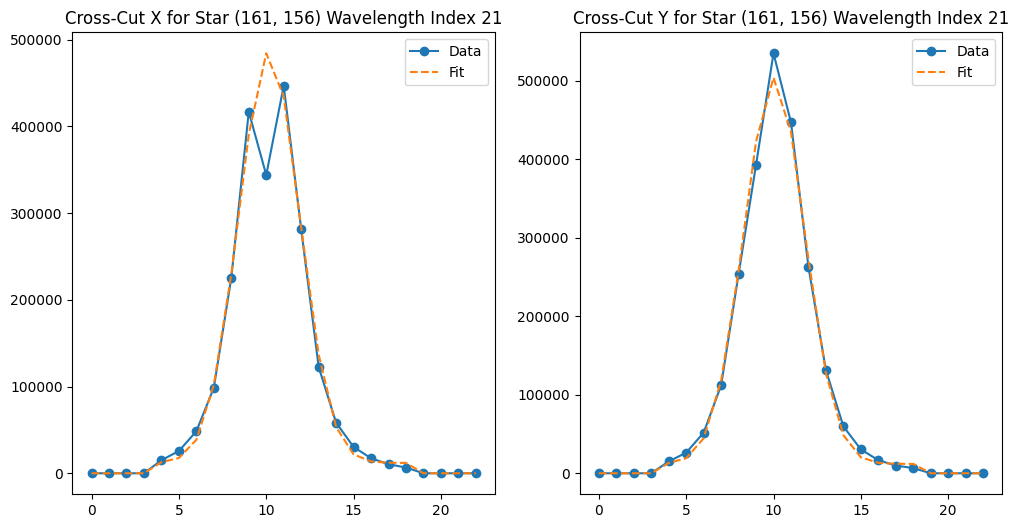

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3137.625732421875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5029.23517
    reduced chi-square = 22.8601599
    Akaike info crit   = 709.057629
    Bayesian info crit = 726.138131
[[Variables]]
    x0:      6.17053754 +/- 0.02164754 (0.35%) (init = 6)
    y0:      6.04301132 +/- 0.02164754 (0.36%) (init = 6)
    sigma:   1.73168885 +/- 0.01711813 (0.99%) (init = 1)
    height:  552938.376 +/- 6912.00986 (1.25%) (init = 685706.1)
    offset:  12006.0241 +/- 1225.76457 (10.21%) (init = 16371.86)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6320
    C(sigma, offset) = -0.4477
{'x0': 6.170537542734725, 'y0': 6.043011323049642, 'sigma': 1.7316888470841612, 'height': 552938.3763332472, 'offset': 12006.024077408652}
Chi-squared: 5029.235171

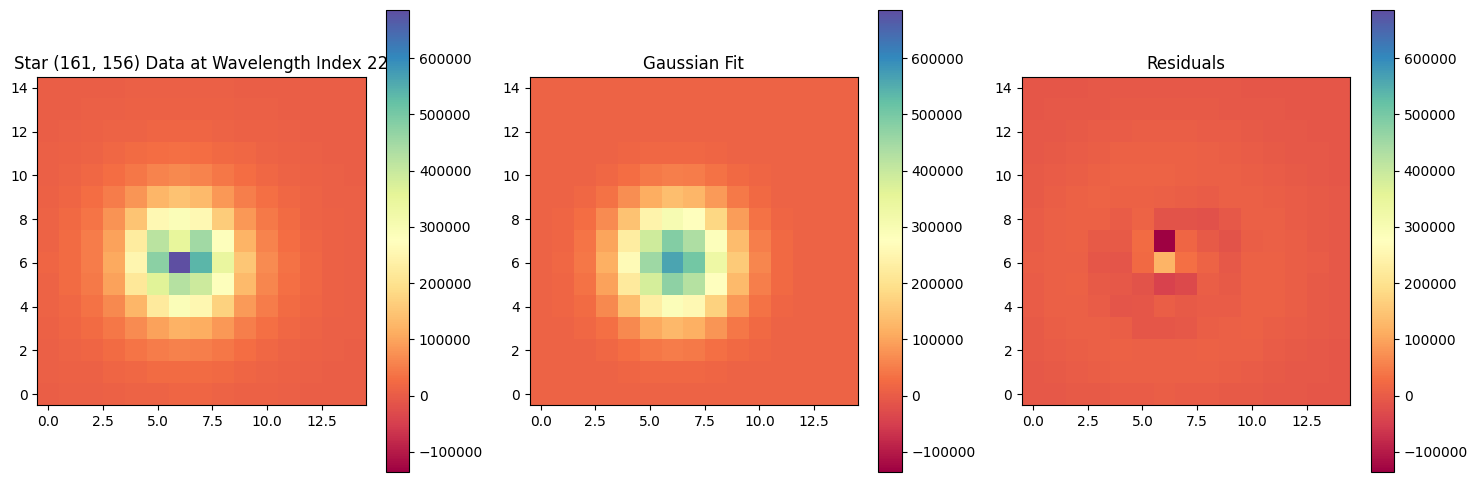

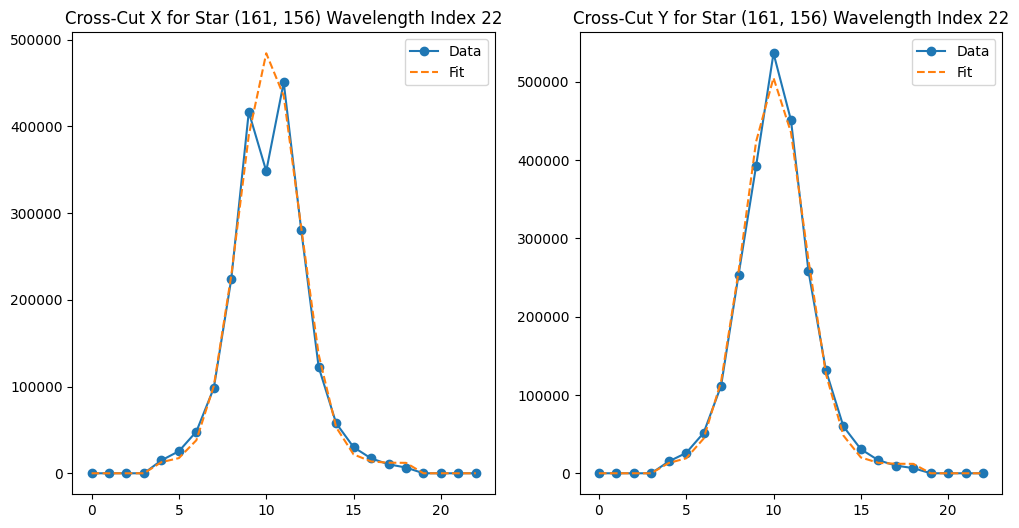

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3141.969970703125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5188.05241
    reduced chi-square = 23.5820564
    Akaike info crit   = 716.052980
    Bayesian info crit = 733.133482
[[Variables]]
    x0:      6.15874919 +/- 0.02193579 (0.36%) (init = 6)
    y0:      6.03590470 +/- 0.02193579 (0.36%) (init = 6)
    sigma:   1.72914708 +/- 0.01733844 (1.00%) (init = 1)
    height:  554988.450 +/- 7040.35428 (1.27%) (init = 680795.2)
    offset:  12054.4988 +/- 1245.77605 (10.33%) (init = 16346.19)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6323
    C(sigma, offset) = -0.4469
{'x0': 6.158749192606236, 'y0': 6.03590470281808, 'sigma': 1.7291470780272484, 'height': 554988.4503912322, 'offset': 12054.498808870183}
Chi-squared: 5188.0524119

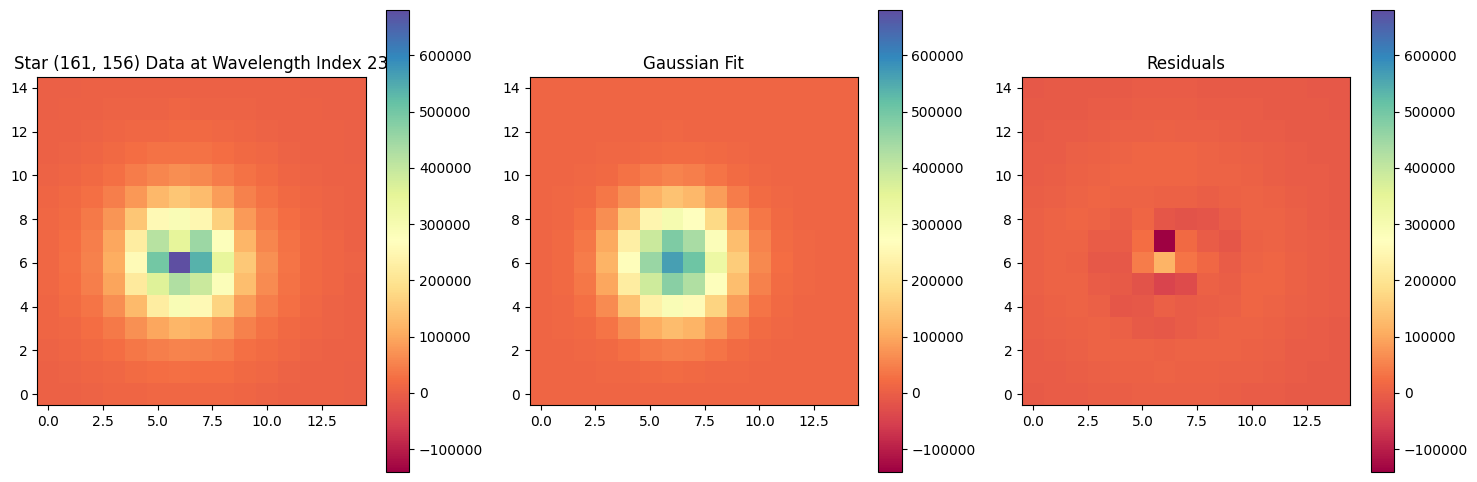

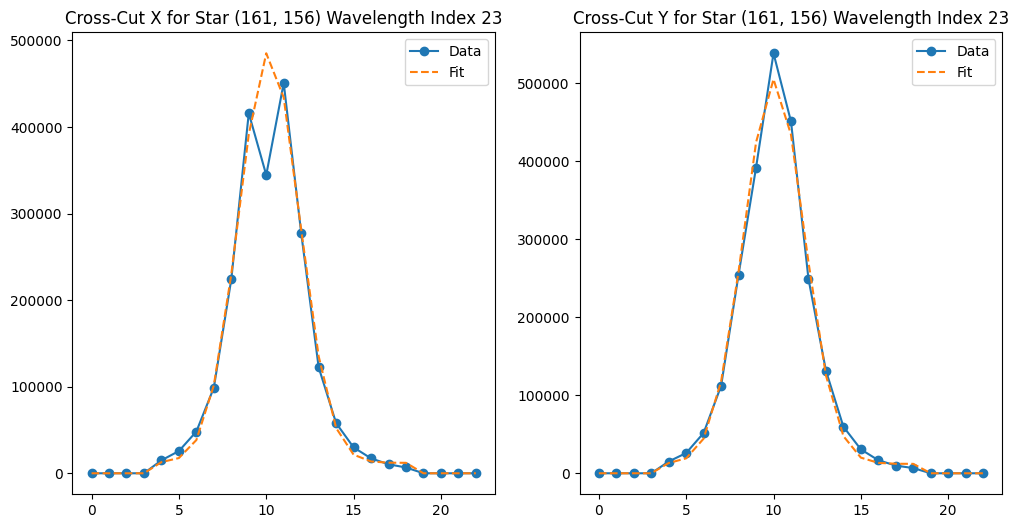

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3162.205322265625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5234.53655
    reduced chi-square = 23.7933479
    Akaike info crit   = 718.059967
    Bayesian info crit = 735.140469
[[Variables]]
    x0:      6.15694445 +/- 0.02224446 (0.36%) (init = 6)
    y0:      6.03632201 +/- 0.02224446 (0.37%) (init = 6)
    sigma:   1.73176449 +/- 0.01759021 (1.02%) (init = 1)
    height:  553274.310 +/- 7106.60850 (1.28%) (init = 678726.3)
    offset:  12031.0918 +/- 1260.34382 (10.48%) (init = 16220.39)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6320
    C(sigma, offset) = -0.4477
{'x0': 6.156944448609455, 'y0': 6.036322005688976, 'sigma': 1.731764493355058, 'height': 553274.309973924, 'offset': 12031.091773281583}
Chi-squared: 5234.53654772

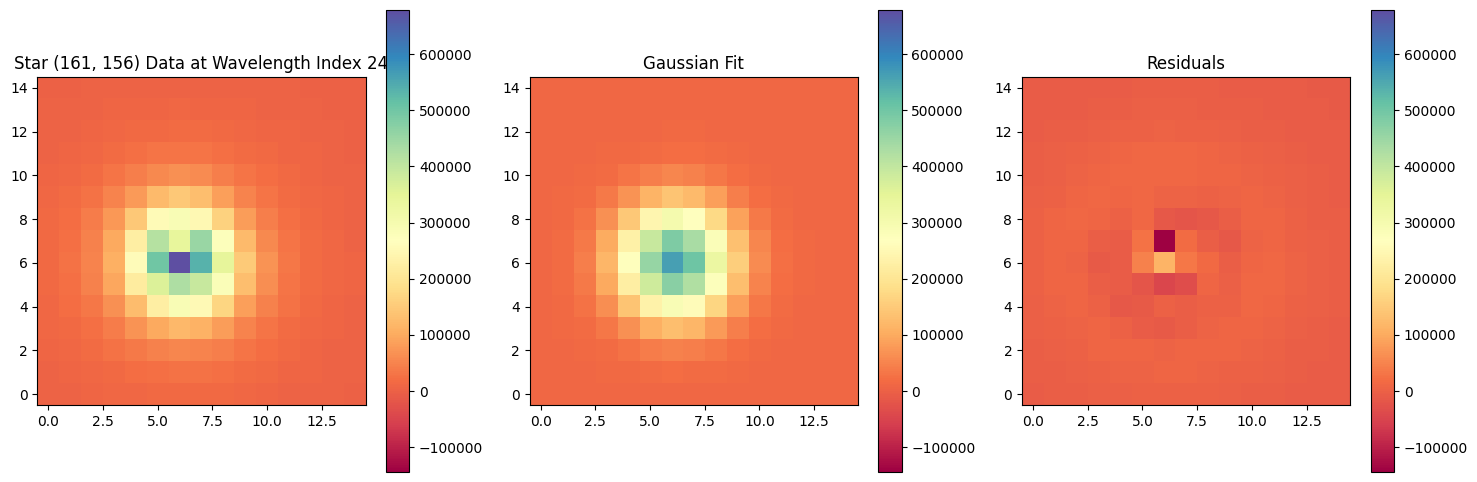

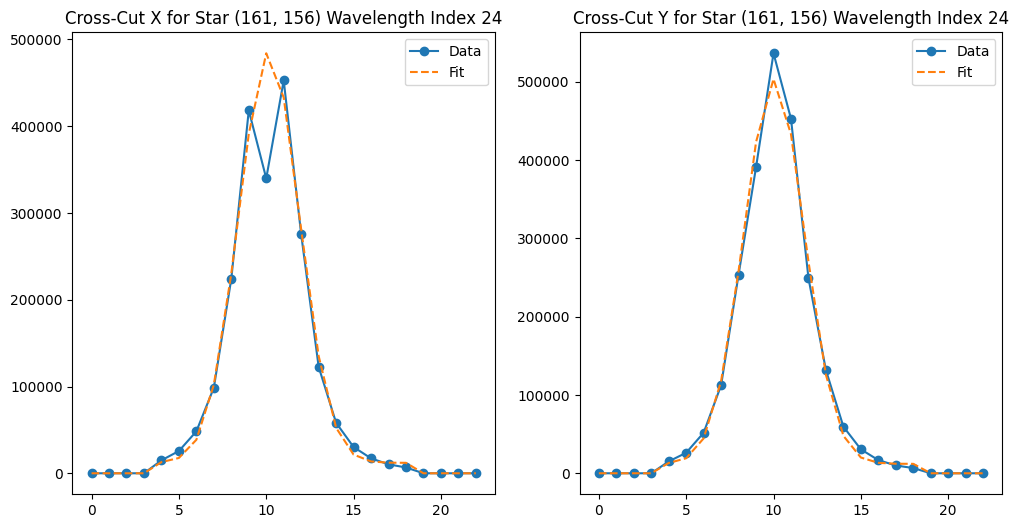

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3185.23291015625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4879.20379
    reduced chi-square = 22.1781991
    Akaike info crit   = 702.243308
    Bayesian info crit = 719.323810
[[Variables]]
    x0:      6.16256605 +/- 0.02177974 (0.35%) (init = 6)
    y0:      6.03474030 +/- 0.02177974 (0.36%) (init = 6)
    sigma:   1.73933419 +/- 0.01724501 (0.99%) (init = 1)
    height:  549537.067 +/- 6881.03668 (1.25%) (init = 667669.4)
    offset:  12004.4832 +/- 1228.34206 (10.23%) (init = 16386.89)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6312
    C(sigma, offset) = -0.4500
{'x0': 6.162566053024016, 'y0': 6.034740300955713, 'sigma': 1.7393341870565588, 'height': 549537.0674370965, 'offset': 12004.483221436161}
Chi-squared: 4879.2037910

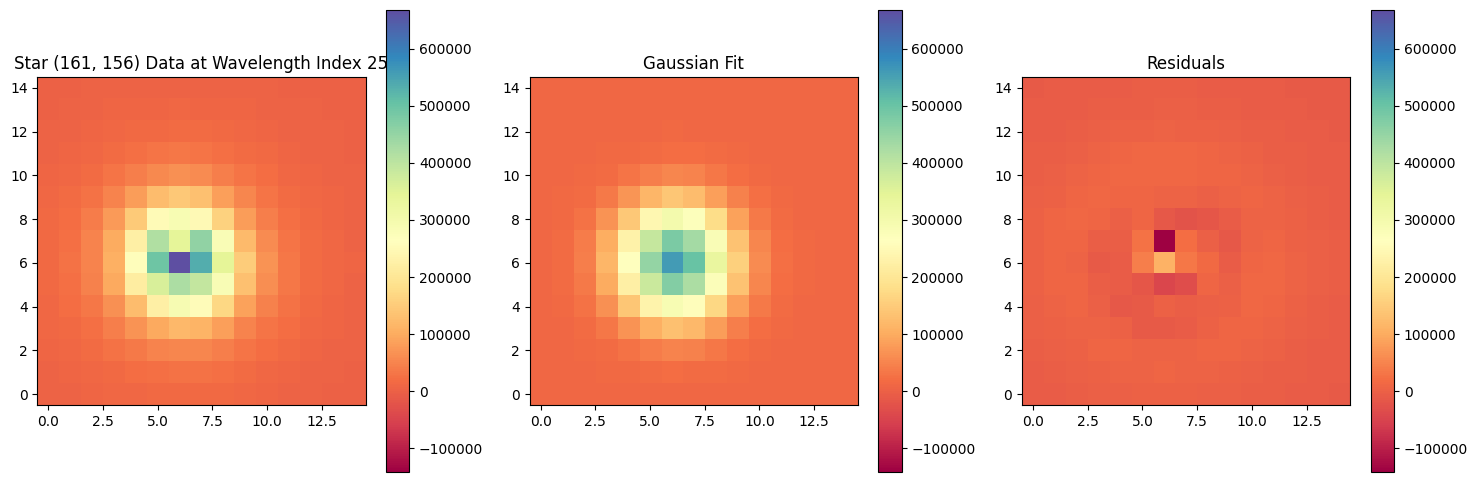

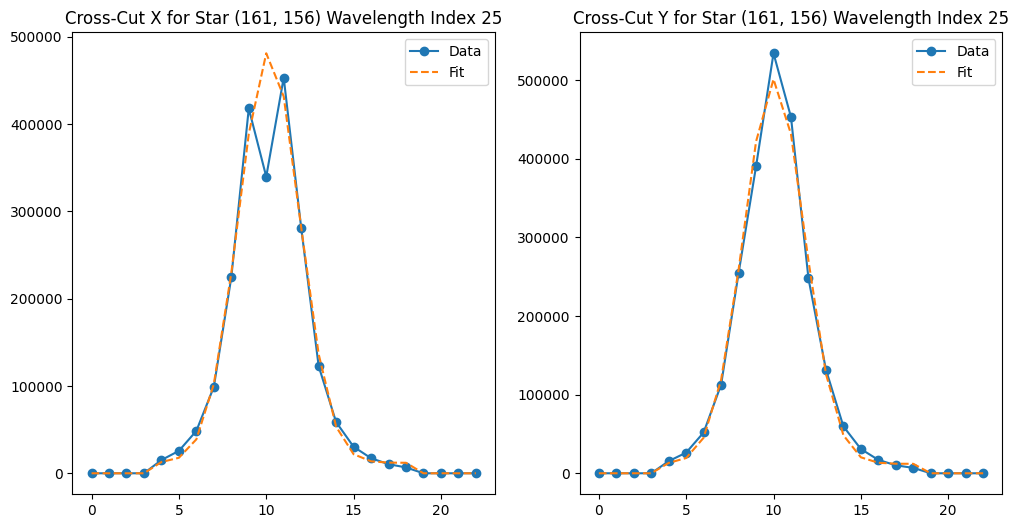

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3214.385009765625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4648.09274
    reduced chi-square = 21.1276943
    Akaike info crit   = 691.325166
    Bayesian info crit = 708.405668
[[Variables]]
    x0:      6.17517688 +/- 0.02165810 (0.35%) (init = 6)
    y0:      6.03778221 +/- 0.02165810 (0.36%) (init = 6)
    sigma:   1.74382332 +/- 0.01716206 (0.98%) (init = 1)
    height:  544313.615 +/- 6760.11002 (1.24%) (init = 670266.9)
    offset:  12036.1133 +/- 1211.44937 (10.07%) (init = 16584.38)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6307
    C(sigma, offset) = -0.4513
{'x0': 6.175176878104317, 'y0': 6.037782210453347, 'sigma': 1.743823321213812, 'height': 544313.6153589676, 'offset': 12036.11327566846}
Chi-squared: 4648.09274252

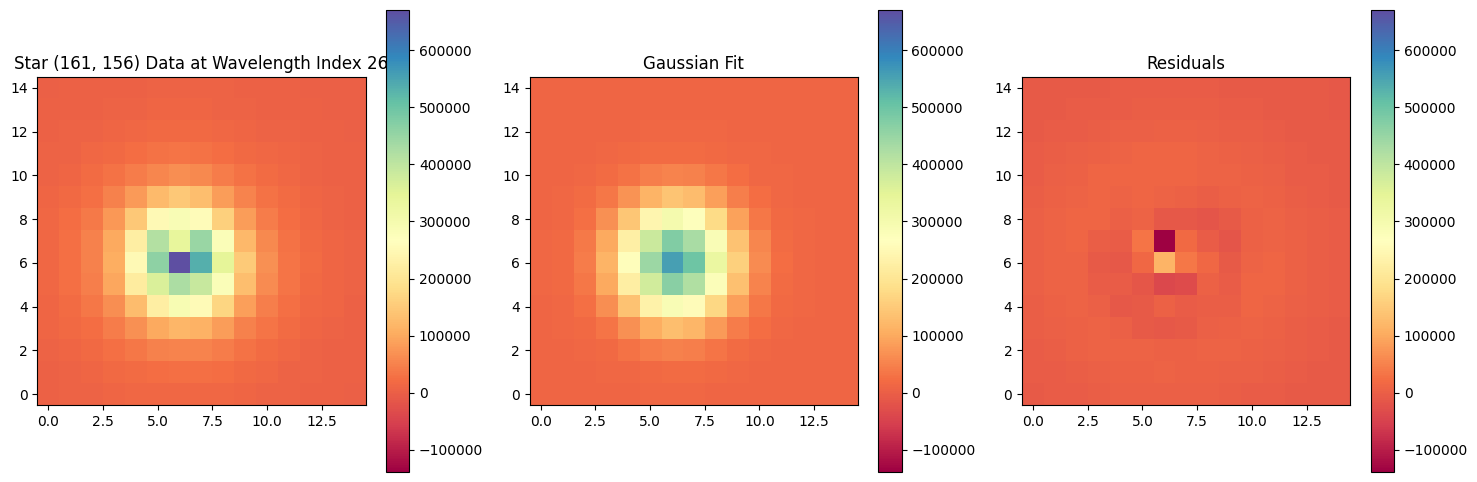

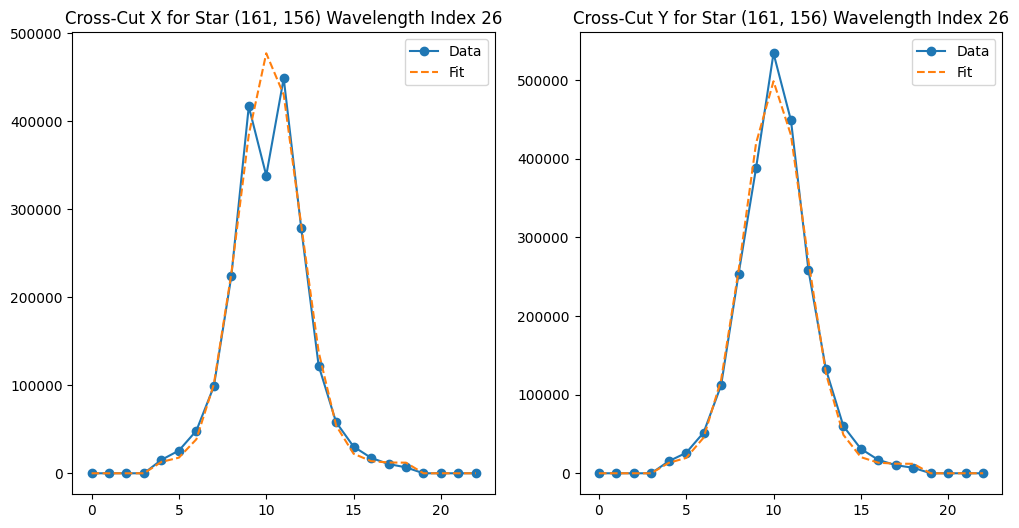

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3155.031005859375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4858.12080
    reduced chi-square = 22.0823673
    Akaike info crit   = 701.268979
    Bayesian info crit = 718.349481
[[Variables]]
    x0:      6.17351002 +/- 0.02180408 (0.35%) (init = 6)
    y0:      6.03338970 +/- 0.02180408 (0.36%) (init = 6)
    sigma:   1.74452586 +/- 0.01727977 (0.99%) (init = 1)
    height:  542543.244 +/- 6780.80586 (1.25%) (init = 668737.6)
    offset:  11909.1876 +/- 1215.89032 (10.21%) (init = 16401.93)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6306
    C(sigma, offset) = -0.4515
{'x0': 6.173510015865195, 'y0': 6.033389701165885, 'sigma': 1.7445258644058041, 'height': 542543.244356559, 'offset': 11909.187620317047}
Chi-squared: 4858.1208042

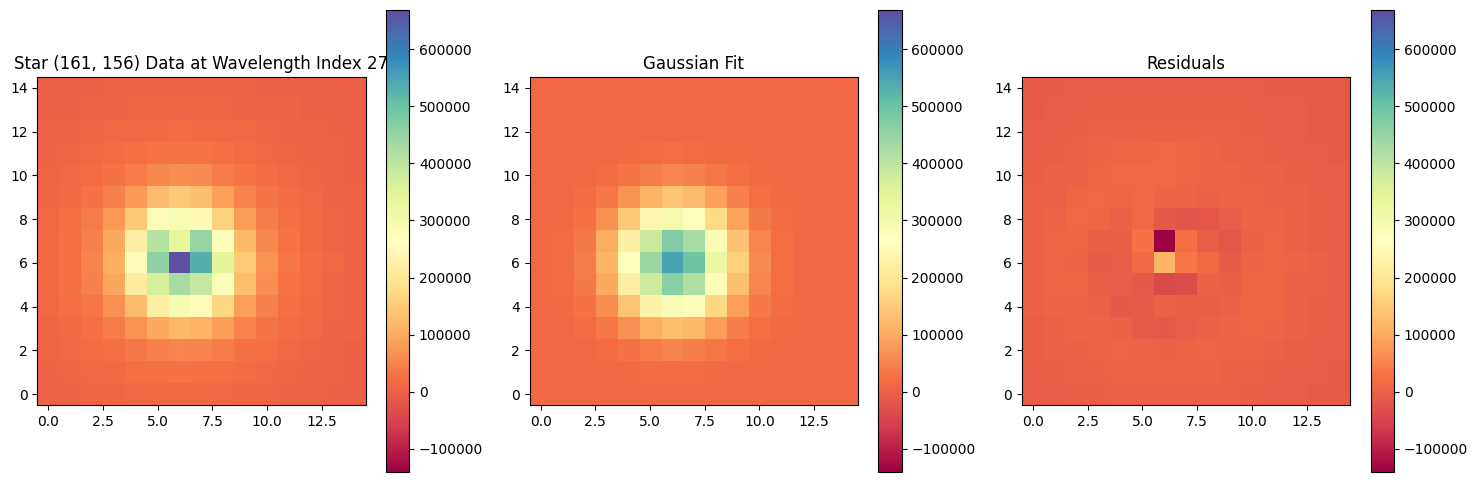

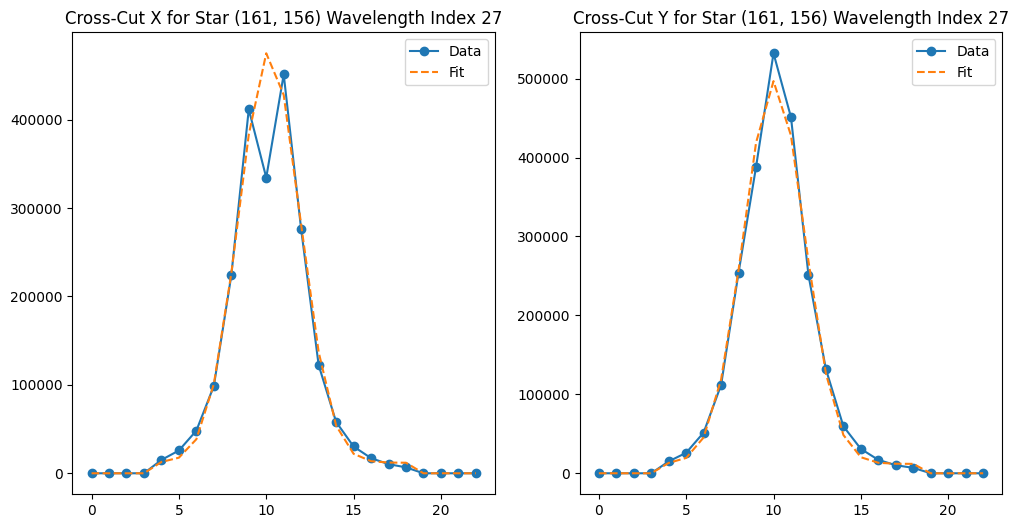

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3135.01953125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5026.52735
    reduced chi-square = 22.8478516
    Akaike info crit   = 708.936453
    Bayesian info crit = 726.016955
[[Variables]]
    x0:      6.17509388 +/- 0.02199487 (0.36%) (init = 6)
    y0:      6.03720586 +/- 0.02199487 (0.36%) (init = 6)
    sigma:   1.74092541 +/- 0.01742022 (1.00%) (init = 1)
    height:  543609.329 +/- 6867.76406 (1.26%) (init = 672549.2)
    offset:  11858.9941 +/- 1227.66658 (10.35%) (init = 16281.66)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6310
    C(sigma, offset) = -0.4505
{'x0': 6.175093883305741, 'y0': 6.037205860926299, 'sigma': 1.7409254109267827, 'height': 543609.3291166325, 'offset': 11858.994065342782}
Chi-squared: 5026.5273501008

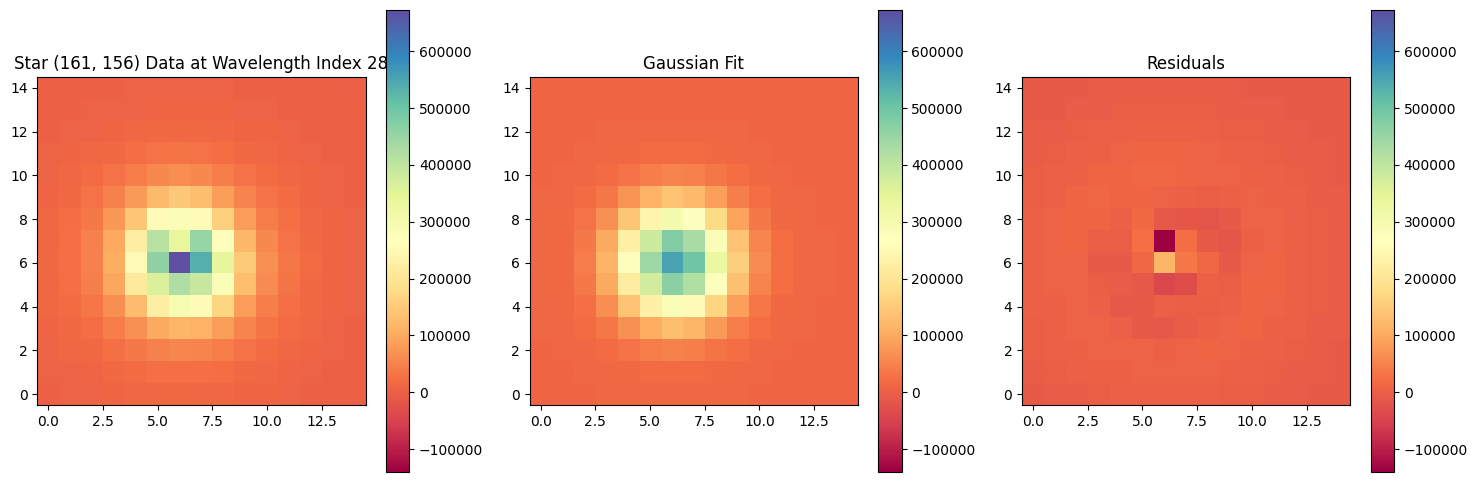

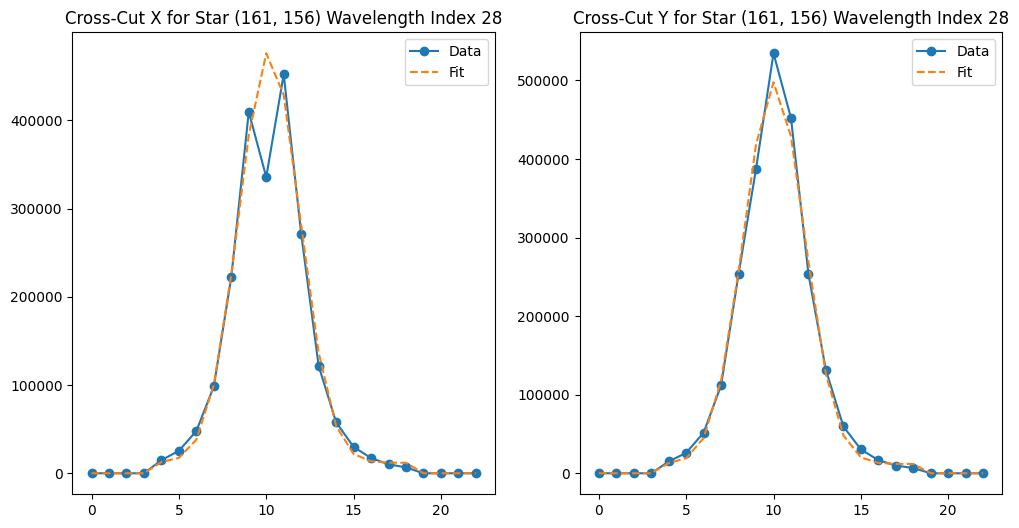

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3106.173583984375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5044.86642
    reduced chi-square = 22.9312110
    Akaike info crit   = 709.755862
    Bayesian info crit = 726.836364
[[Variables]]
    x0:      6.17698170 +/- 0.02182212 (0.35%) (init = 6)
    y0:      6.03779965 +/- 0.02182212 (0.36%) (init = 6)
    sigma:   1.74181046 +/- 0.01728606 (0.99%) (init = 1)
    height:  543860.700 +/- 6813.50859 (1.25%) (init = 672340)
    offset:  11795.7526 +/- 1218.90049 (10.33%) (init = 16219.21)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6309
    C(sigma, offset) = -0.4507
{'x0': 6.176981702968461, 'y0': 6.037799645637487, 'sigma': 1.741810461413243, 'height': 543860.6998961442, 'offset': 11795.752605890113}
Chi-squared: 5044.866415725

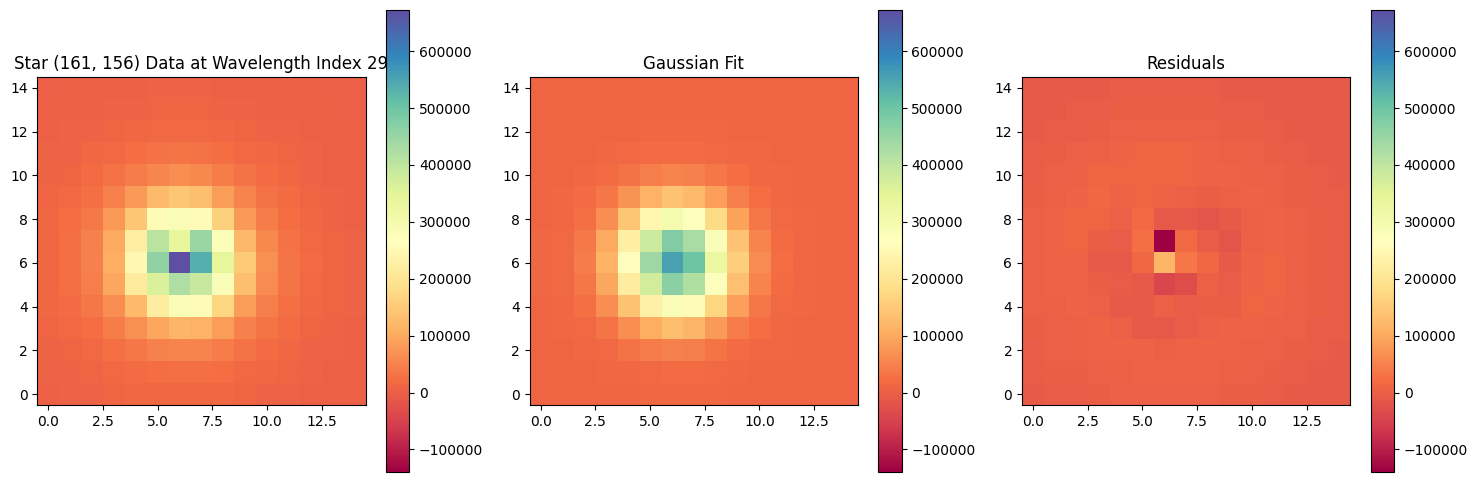

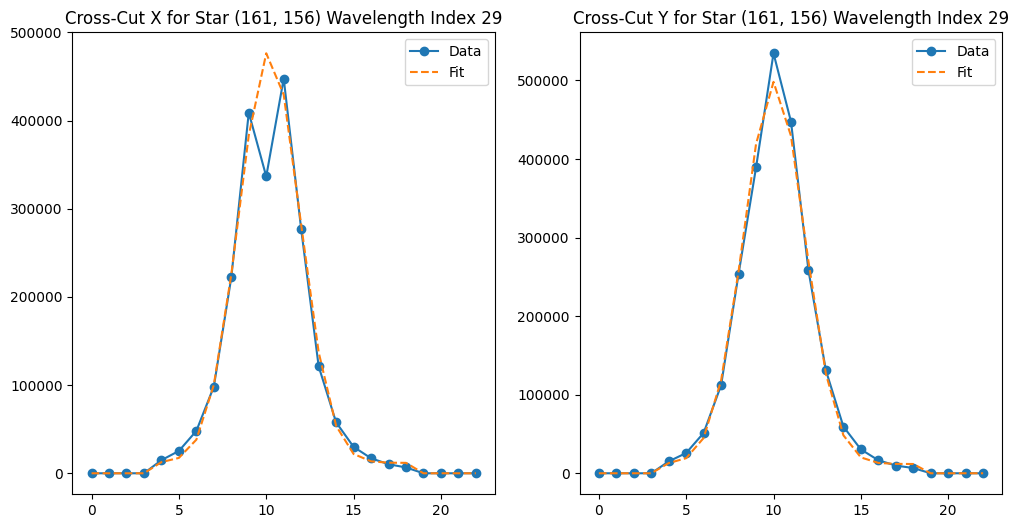

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3118.775634765625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5072.09889
    reduced chi-square = 23.0549950
    Akaike info crit   = 710.967158
    Bayesian info crit = 728.047660
[[Variables]]
    x0:      6.17474546 +/- 0.02188771 (0.35%) (init = 6)
    y0:      6.03888196 +/- 0.02188771 (0.36%) (init = 6)
    sigma:   1.73759697 +/- 0.01732548 (1.00%) (init = 1)
    height:  545898.108 +/- 6876.22709 (1.26%) (init = 671309.8)
    offset:  11860.7659 +/- 1225.65535 (10.33%) (init = 16238.75)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4495
{'x0': 6.174745455732452, 'y0': 6.038881958523262, 'sigma': 1.7375969676138425, 'height': 545898.1079883919, 'offset': 11860.765858624613}
Chi-squared: 5072.098891

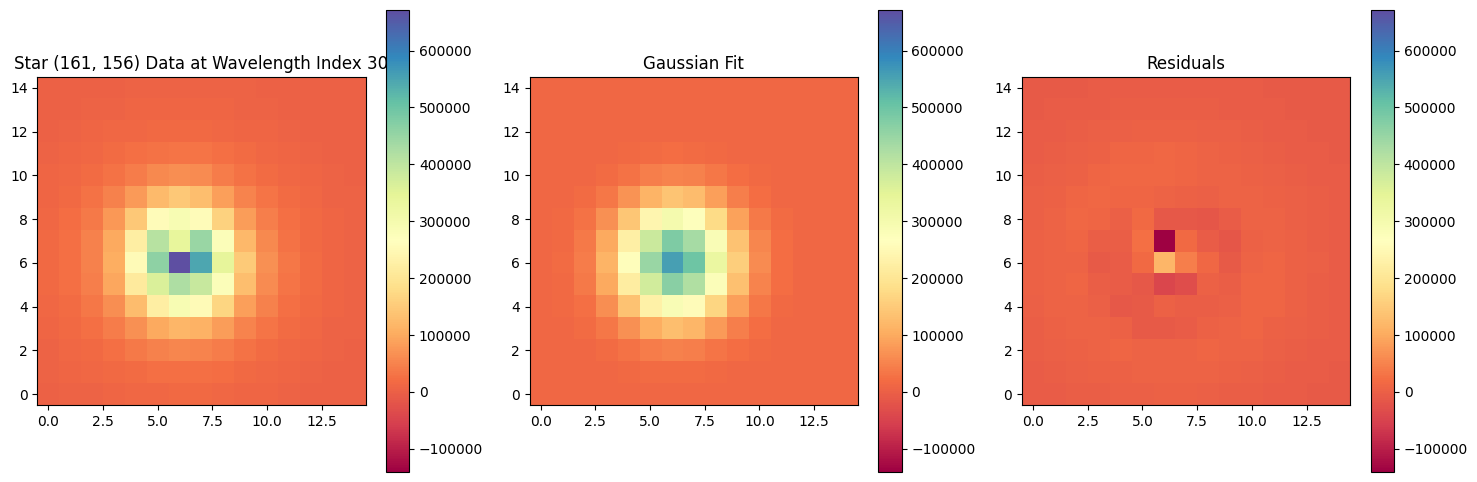

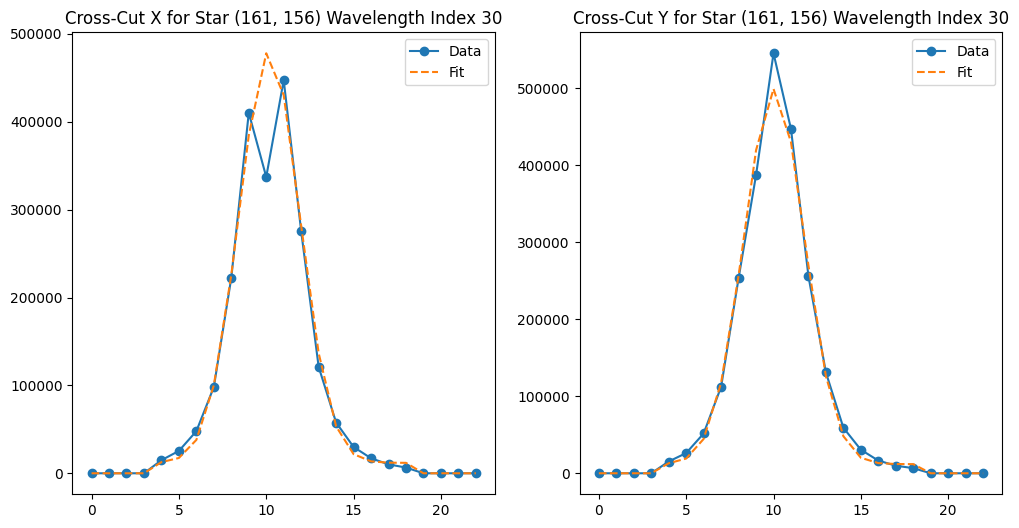

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3126.779052734375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5100.65027
    reduced chi-square = 23.1847740
    Akaike info crit   = 712.230155
    Bayesian info crit = 729.310657
[[Variables]]
    x0:      6.15541768 +/- 0.02196104 (0.36%) (init = 6)
    y0:      6.03550372 +/- 0.02196104 (0.36%) (init = 6)
    sigma:   1.73699449 +/- 0.01738155 (1.00%) (init = 1)
    height:  547004.391 +/- 6915.65147 (1.26%) (init = 664199.1)
    offset:  11836.5855 +/- 1232.02629 (10.41%) (init = 16200.51)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4492
{'x0': 6.1554176820386175, 'y0': 6.035503723192689, 'sigma': 1.736994490053657, 'height': 547004.391315098, 'offset': 11836.585548647236}
Chi-squared: 5100.6502719

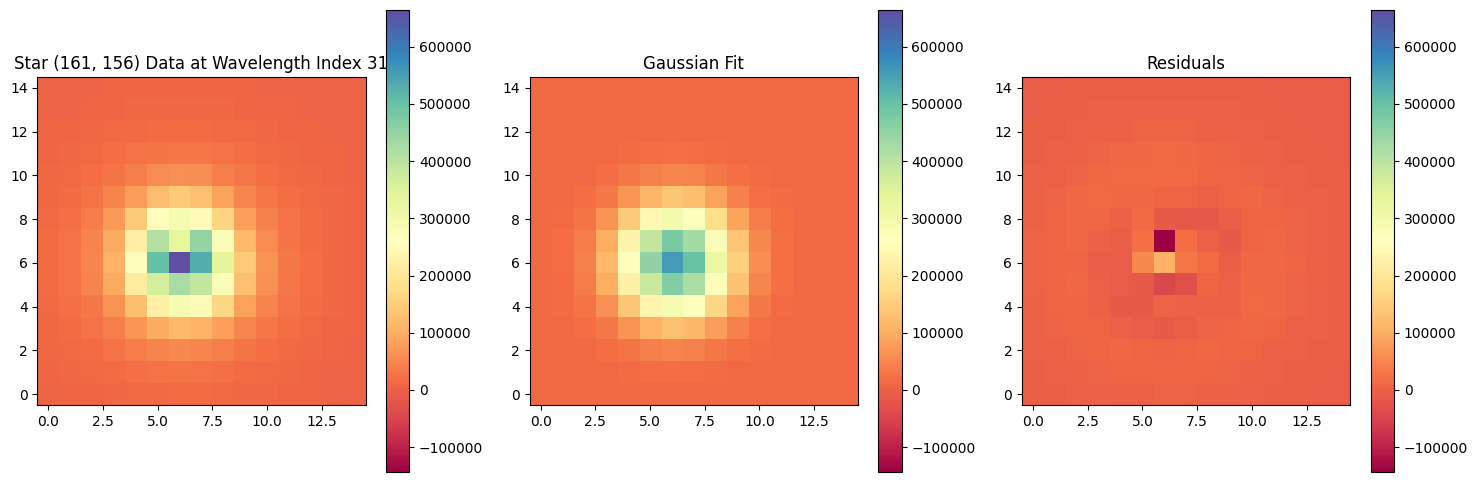

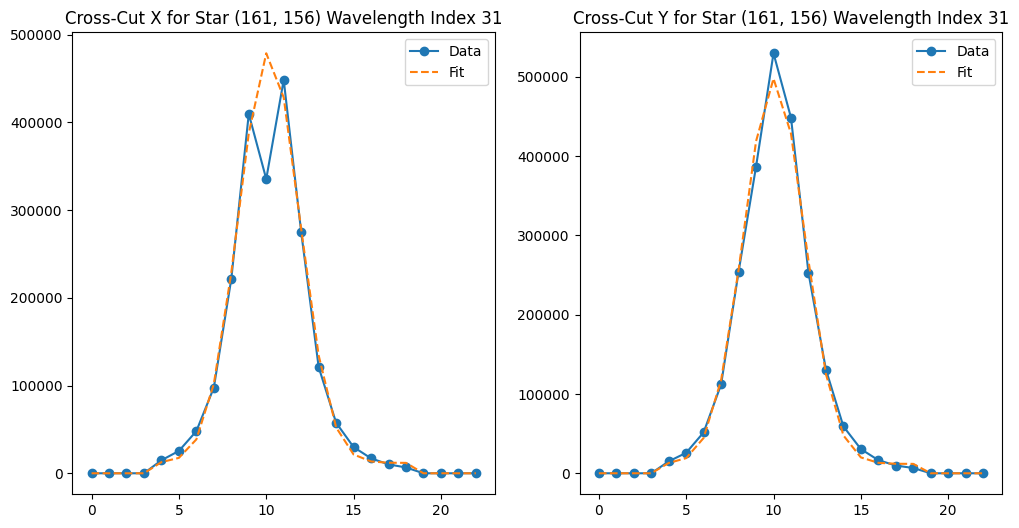

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3110.620849609375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5084.90006
    reduced chi-square = 23.1131821
    Akaike info crit   = 711.534307
    Bayesian info crit = 728.614809
[[Variables]]
    x0:      6.17693621 +/- 0.02190822 (0.35%) (init = 6)
    y0:      6.03236934 +/- 0.02190822 (0.36%) (init = 6)
    sigma:   1.73680232 +/- 0.01733931 (1.00%) (init = 1)
    height:  544647.111 +/- 6870.03760 (1.26%) (init = 665992.3)
    offset:  11863.5457 +/- 1223.70914 (10.31%) (init = 16121.37)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4492
{'x0': 6.176936211861846, 'y0': 6.032369340955781, 'sigma': 1.7368023249763345, 'height': 544647.1105594295, 'offset': 11863.545736537622}
Chi-squared: 5084.900055

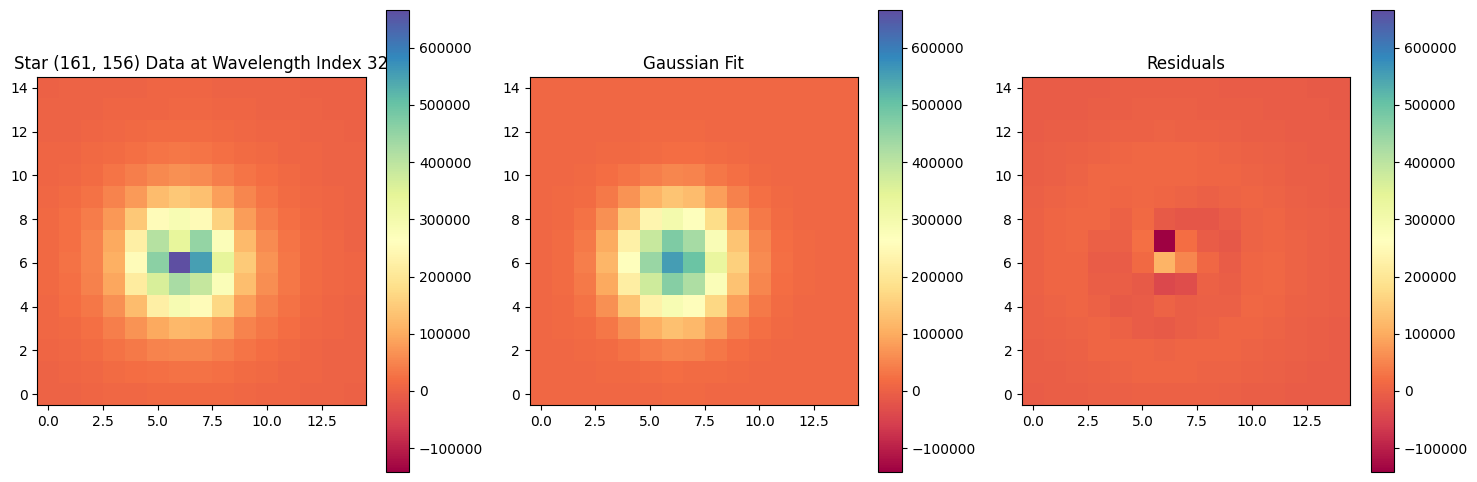

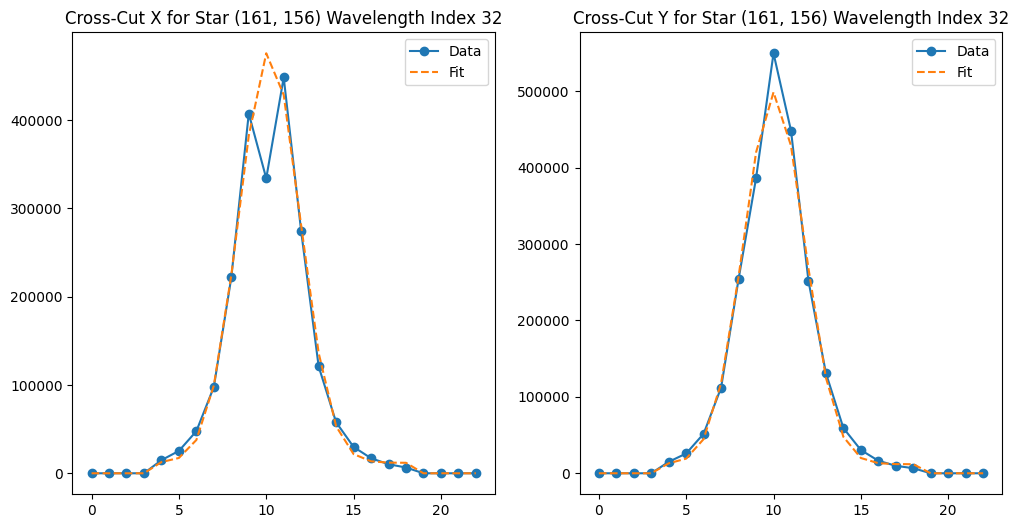

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3106.012939453125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4980.89962
    reduced chi-square = 22.6404528
    Akaike info crit   = 706.884715
    Bayesian info crit = 723.965217
[[Variables]]
    x0:      6.17617046 +/- 0.02155474 (0.35%) (init = 6)
    y0:      6.02465211 +/- 0.02155474 (0.36%) (init = 6)
    sigma:   1.73164224 +/- 0.01704448 (0.98%) (init = 1)
    height:  547076.197 +/- 6809.58697 (1.24%) (init = 665951)
    offset:  11925.5579 +/- 1207.54339 (10.13%) (init = 16141.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6320
    C(sigma, offset) = -0.4476
{'x0': 6.176170464490012, 'y0': 6.024652109398083, 'sigma': 1.7316422370170264, 'height': 547076.1970151014, 'offset': 11925.557887164272}
Chi-squared: 4980.89961871

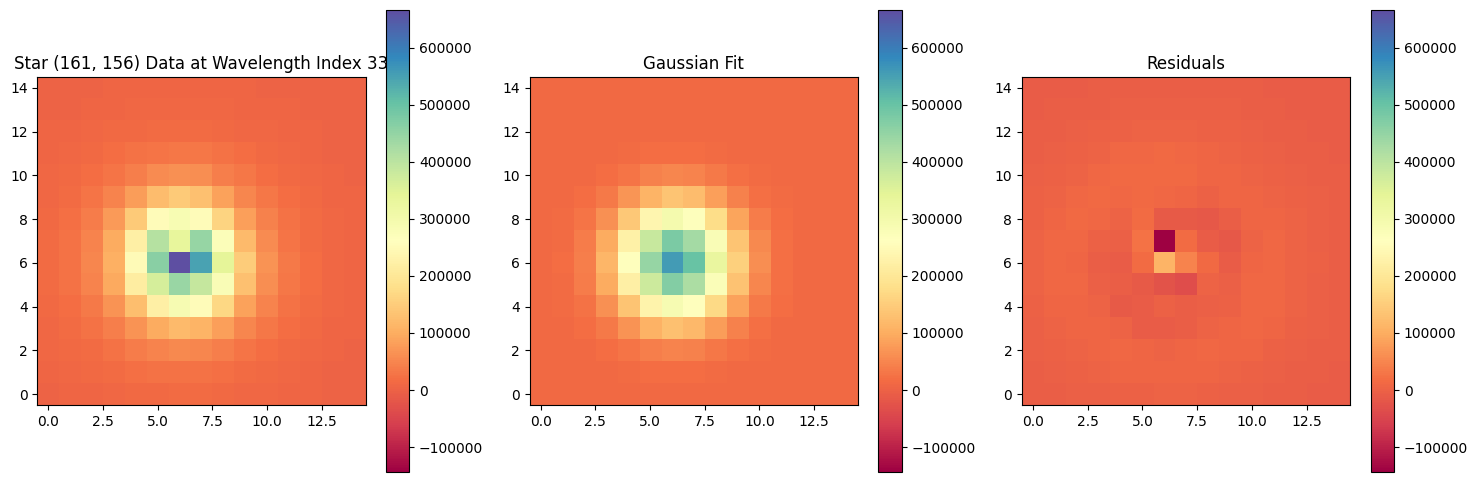

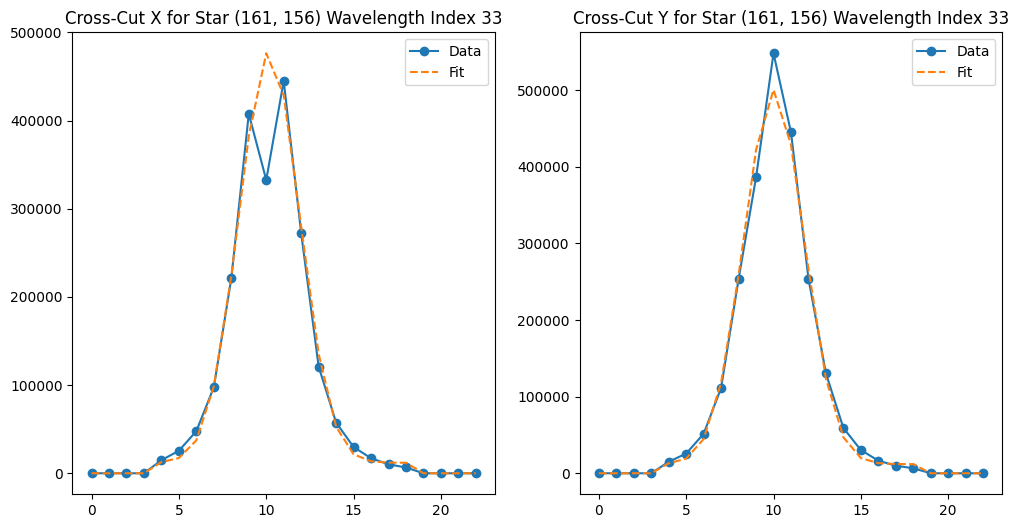

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3101.8583984375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 4968.55355
    reduced chi-square = 22.5843343
    Akaike info crit   = 706.326318
    Bayesian info crit = 723.406820
[[Variables]]
    x0:      6.17457826 +/- 0.02165769 (0.35%) (init = 6)
    y0:      6.03290845 +/- 0.02165769 (0.36%) (init = 6)
    sigma:   1.73675854 +/- 0.01714089 (0.99%) (init = 1)
    height:  543073.545 +/- 6772.02940 (1.25%) (init = 666264.9)
    offset:  11817.2284 +/- 1206.20470 (10.21%) (init = 16145.31)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6314
    C(sigma, offset) = -0.4492
{'x0': 6.174578257451739, 'y0': 6.032908453220189, 'sigma': 1.7367585379540578, 'height': 543073.5451999985, 'offset': 11817.228353272267}
Chi-squared: 4968.55354698

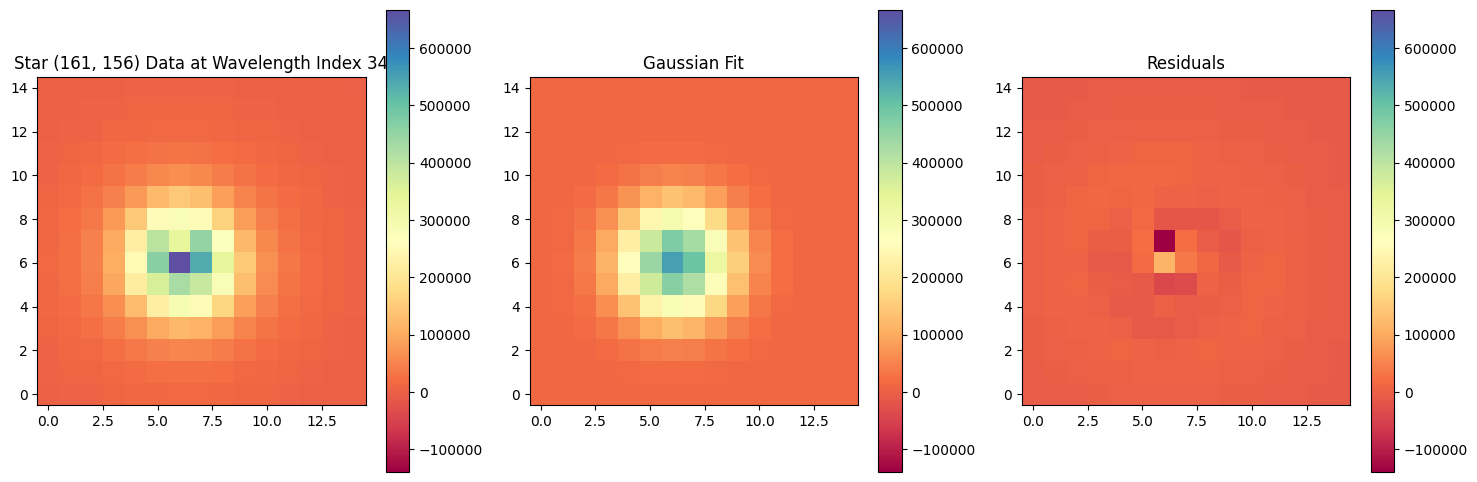

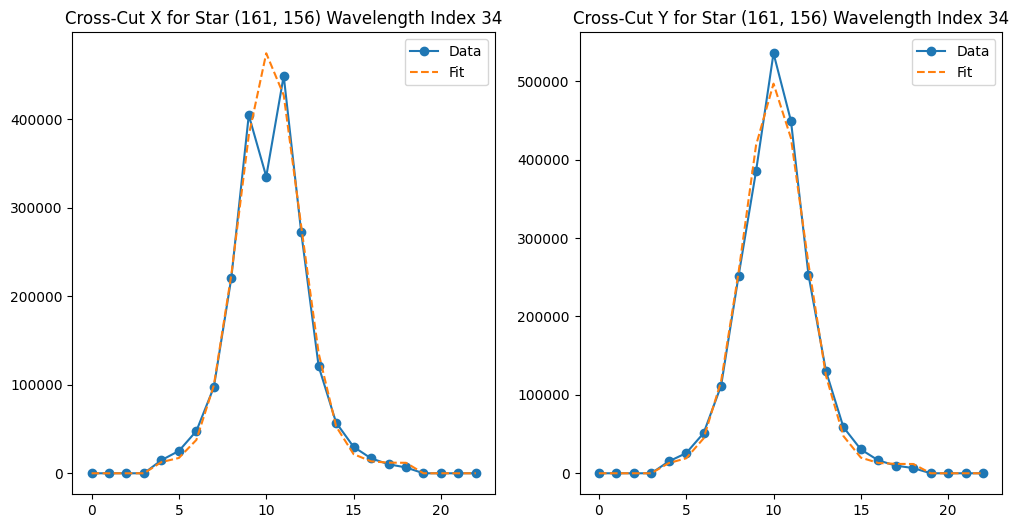

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3090.0673828125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5062.86279
    reduced chi-square = 23.0130127
    Akaike info crit   = 710.557068
    Bayesian info crit = 727.637570
[[Variables]]
    x0:      6.17799680 +/- 0.02180457 (0.35%) (init = 6)
    y0:      6.03459947 +/- 0.02180457 (0.36%) (init = 6)
    sigma:   1.73629138 +/- 0.01725581 (0.99%) (init = 1)
    height:  542441.184 +/- 6811.83880 (1.26%) (init = 658343.7)
    offset:  11808.2761 +/- 1212.81122 (10.27%) (init = 16127.54)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6315
    C(sigma, offset) = -0.4491
{'x0': 6.177996799119793, 'y0': 6.034599466636866, 'sigma': 1.7362913766256918, 'height': 542441.1836405755, 'offset': 11808.276051539768}
Chi-squared: 5062.86279381

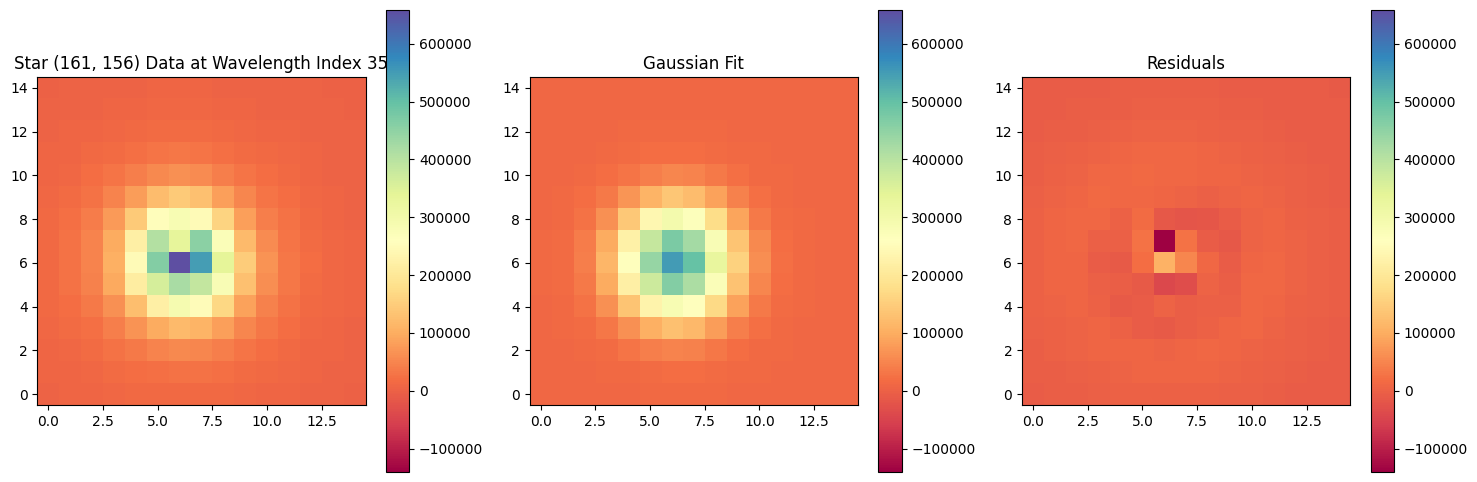

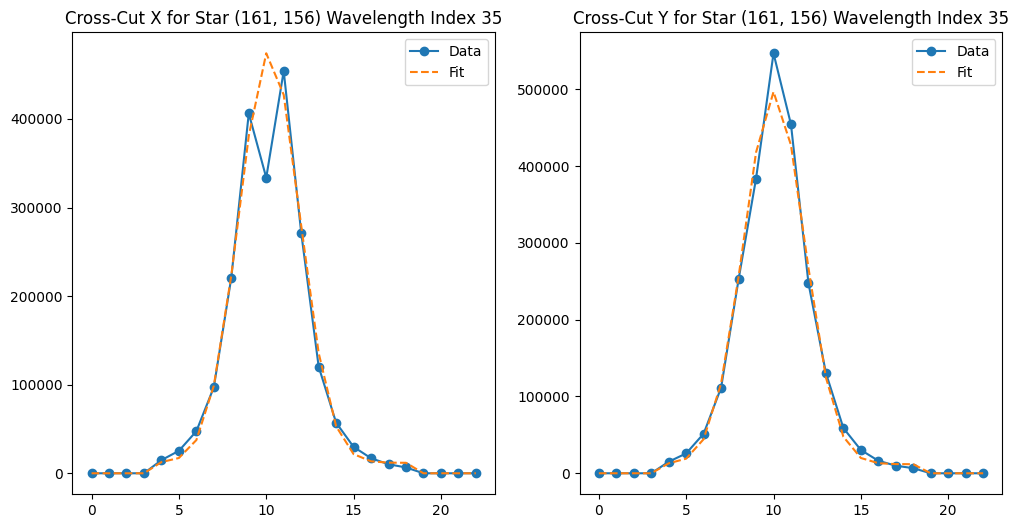

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3086.4609375
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5046.29060
    reduced chi-square = 22.9376846
    Akaike info crit   = 709.819371
    Bayesian info crit = 726.899873
[[Variables]]
    x0:      6.17803438 +/- 0.02182998 (0.35%) (init = 6)
    y0:      6.03482591 +/- 0.02182999 (0.36%) (init = 6)
    sigma:   1.73919935 +/- 0.01728452 (0.99%) (init = 1)
    height:  540291.096 +/- 6781.38422 (1.26%) (init = 655700.8)
    offset:  11744.4185 +/- 1210.42326 (10.31%) (init = 16089.86)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6312
    C(sigma, offset) = -0.4499
{'x0': 6.178034382842832, 'y0': 6.034825909713913, 'sigma': 1.7391993456588801, 'height': 540291.0955739483, 'offset': 11744.418479999405}
Chi-squared: 5046.29060449269

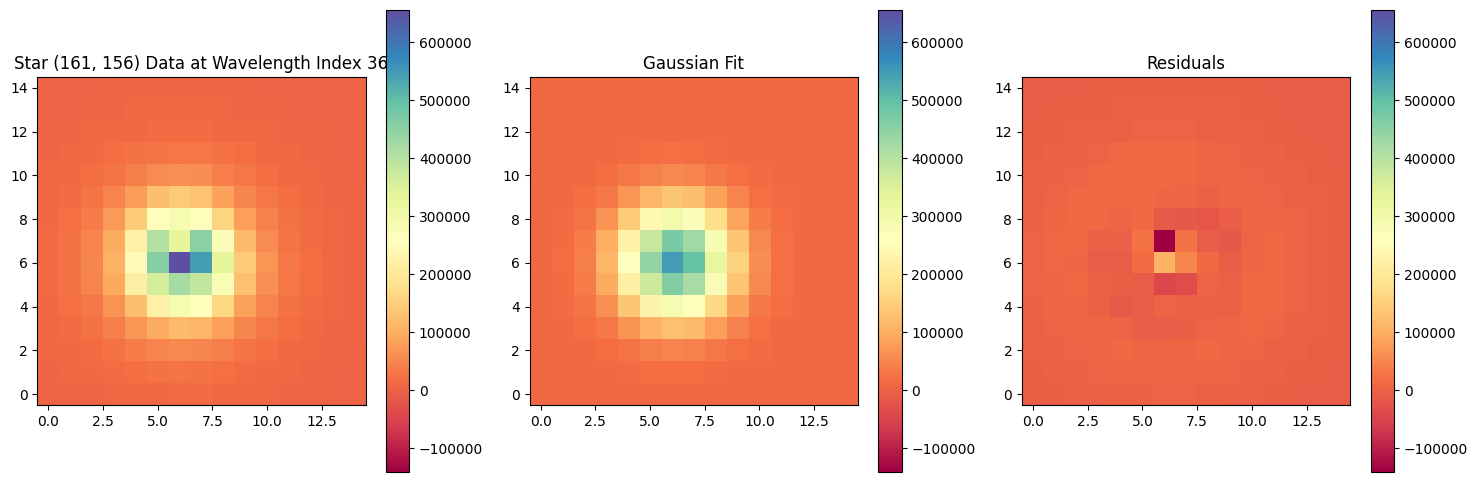

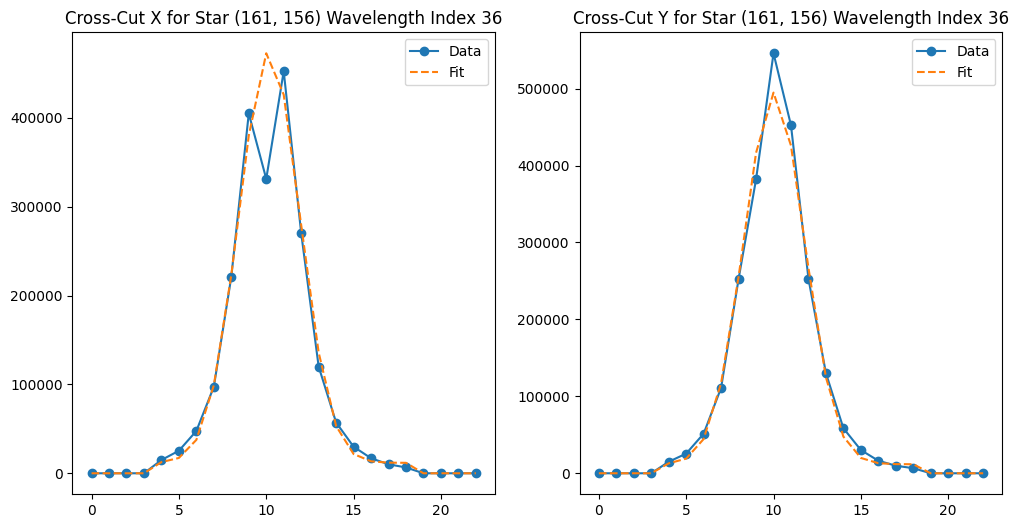

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3076.1923828125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5503.80083
    reduced chi-square = 25.0172765
    Akaike info crit   = 729.346103
    Bayesian info crit = 746.426605
[[Variables]]
    x0:      6.18008994 +/- 0.02257854 (0.37%) (init = 6)
    y0:      6.03651187 +/- 0.02257854 (0.37%) (init = 6)
    sigma:   1.73092156 +/- 0.01785202 (1.03%) (init = 1)
    height:  543729.023 +/- 7092.33273 (1.30%) (init = 668390.4)
    offset:  11875.4967 +/- 1256.91254 (10.58%) (init = 16016.37)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6321
    C(sigma, offset) = -0.4474
{'x0': 6.180089938428336, 'y0': 6.036511866370119, 'sigma': 1.73092156001842, 'height': 543729.023097423, 'offset': 11875.496684941458}
Chi-squared: 5503.80083105855

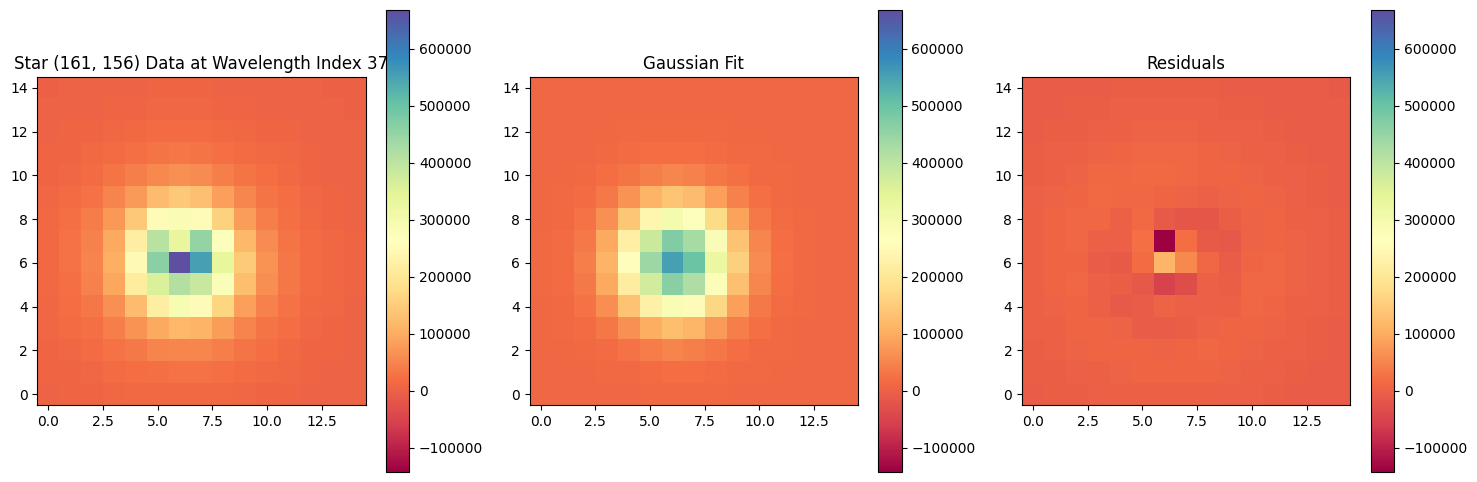

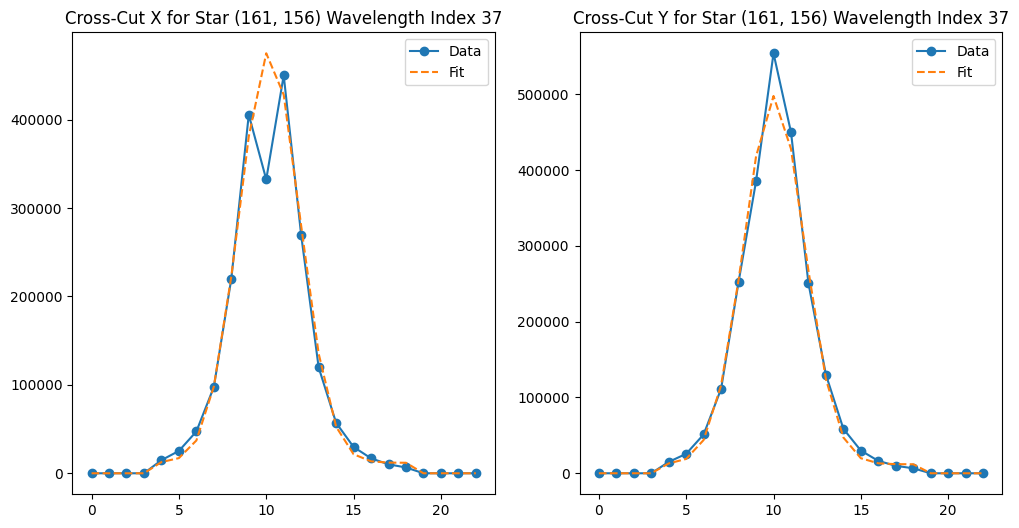

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3075.82421875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5524.25769
    reduced chi-square = 25.1102622
    Akaike info crit   = 730.180846
    Bayesian info crit = 747.261348
[[Variables]]
    x0:      6.17696123 +/- 0.02257811 (0.37%) (init = 6)
    y0:      6.03236711 +/- 0.02257811 (0.37%) (init = 6)
    sigma:   1.72711015 +/- 0.01784010 (1.03%) (init = 1)
    height:  544683.419 +/- 7120.33471 (1.31%) (init = 664101.6)
    offset:  11927.0881 +/- 1257.72379 (10.55%) (init = 15984.09)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6325
    C(sigma, offset) = -0.4463
{'x0': 6.176961225325617, 'y0': 6.0323671077225605, 'sigma': 1.727110146571502, 'height': 544683.4188878844, 'offset': 11927.088149803485}
Chi-squared: 5524.2576901461

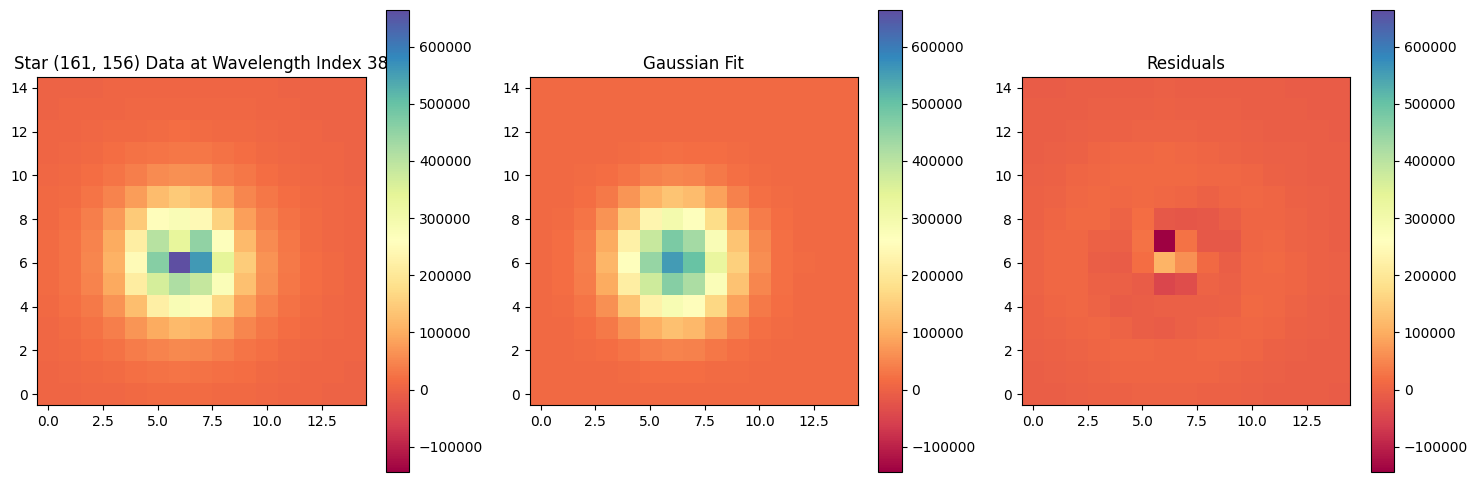

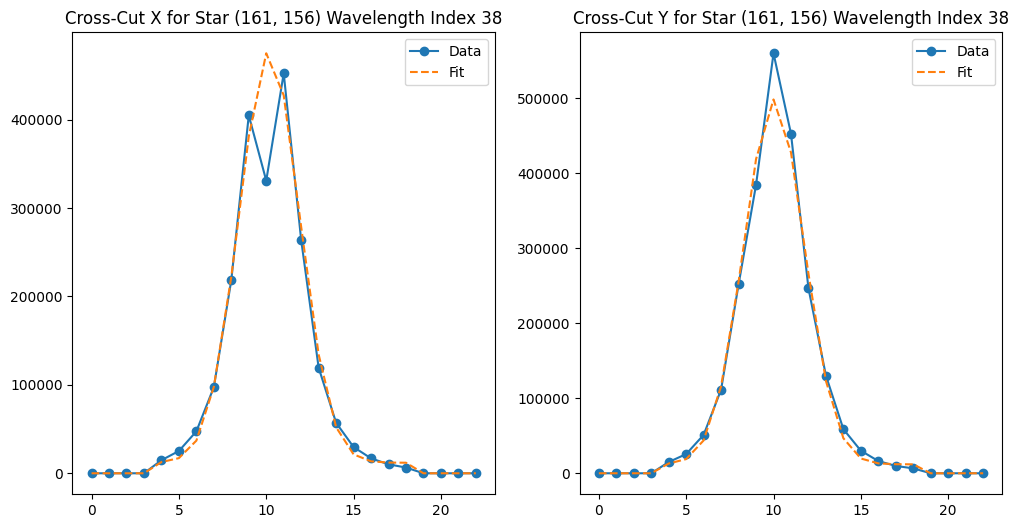

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3080.444091796875
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5474.68089
    reduced chi-square = 24.8849132
    Akaike info crit   = 728.152495
    Bayesian info crit = 745.232997
[[Variables]]
    x0:      6.18288335 +/- 0.02273618 (0.37%) (init = 6)
    y0:      6.03345935 +/- 0.02273619 (0.38%) (init = 6)
    sigma:   1.73273084 +/- 0.01798219 (1.04%) (init = 1)
    height:  539273.236 +/- 7075.92177 (1.31%) (init = 656912.1)
    offset:  11819.8981 +/- 1255.96440 (10.63%) (init = 15995.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6319
    C(sigma, offset) = -0.4480
{'x0': 6.182883346324979, 'y0': 6.033459350623657, 'sigma': 1.7327308405402542, 'height': 539273.2362746577, 'offset': 11819.898063063825}
Chi-squared: 5474.680894

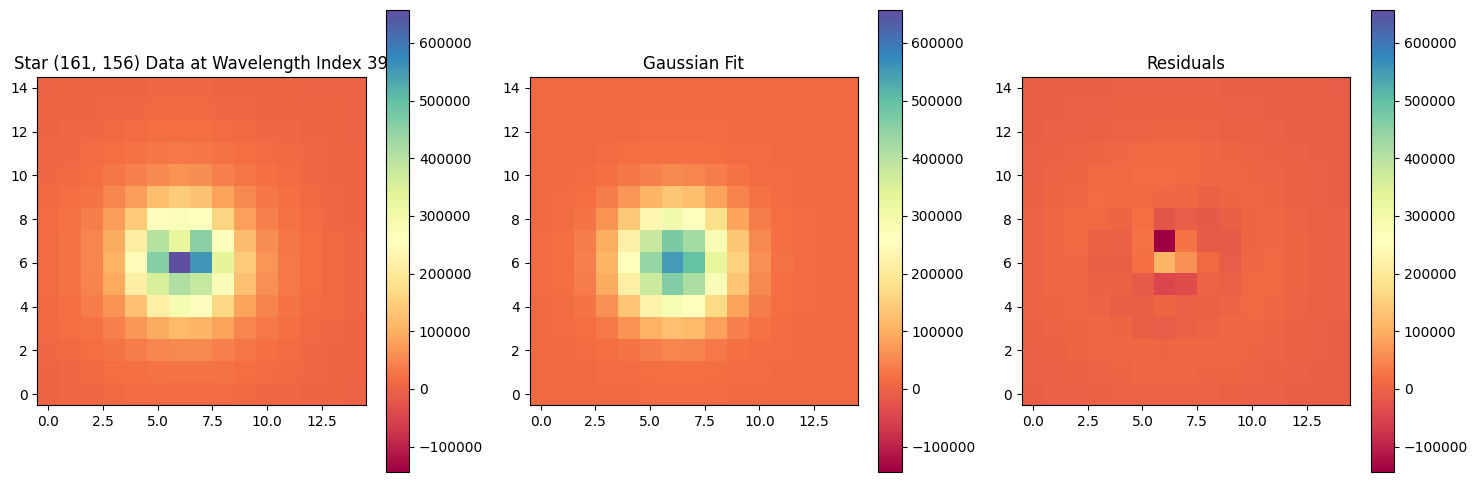

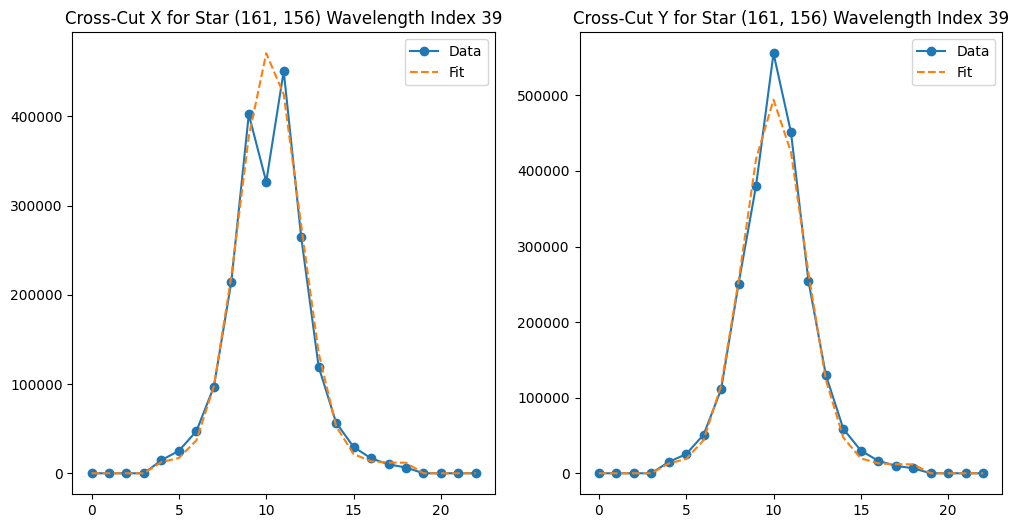

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3059.868408203125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 225
    # variables        = 5
    chi-square         = 5819.42089
    reduced chi-square = 26.4519131
    Akaike info crit   = 741.892517
    Bayesian info crit = 758.973019
[[Variables]]
    x0:      6.21536953 +/- 0.02360781 (0.38%) (init = 6)
    y0:      6.03695814 +/- 0.02360782 (0.39%) (init = 6)
    sigma:   1.74120355 +/- 0.01869886 (1.07%) (init = 1)
    height:  531883.497 +/- 7211.40063 (1.36%) (init = 656716.8)
    offset:  11766.5139 +/- 1289.40471 (10.96%) (init = 16083.82)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6310
    C(sigma, offset) = -0.4506
{'x0': 6.215369529079526, 'y0': 6.03695814266169, 'sigma': 1.741203545613442, 'height': 531883.4965620852, 'offset': 11766.51393095869}
Chi-squared: 5819.420885951

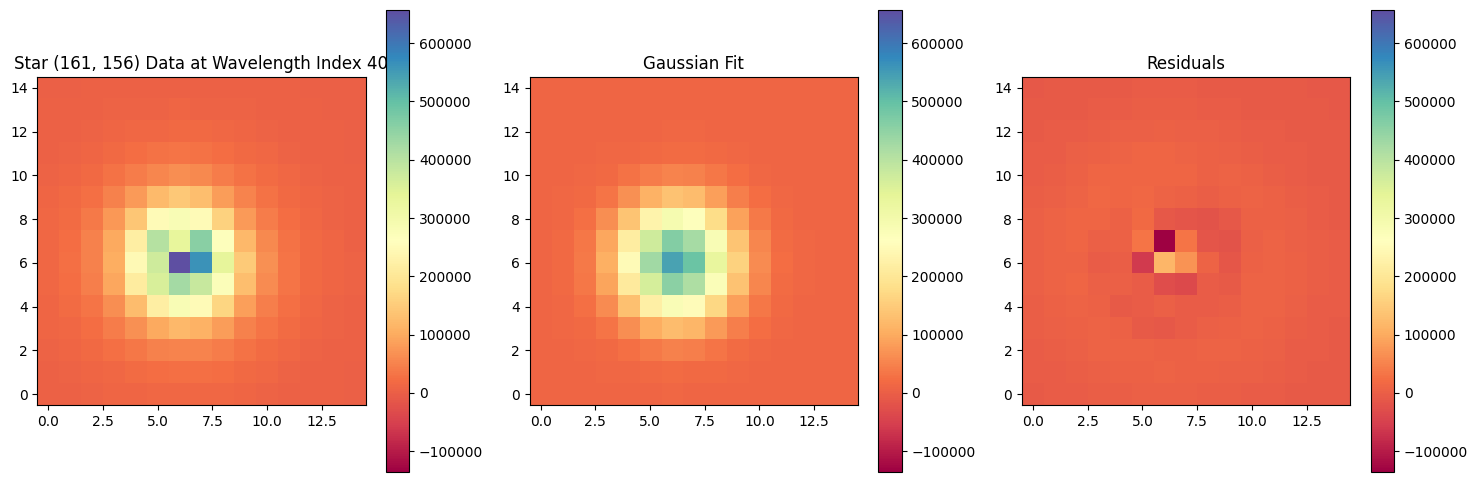

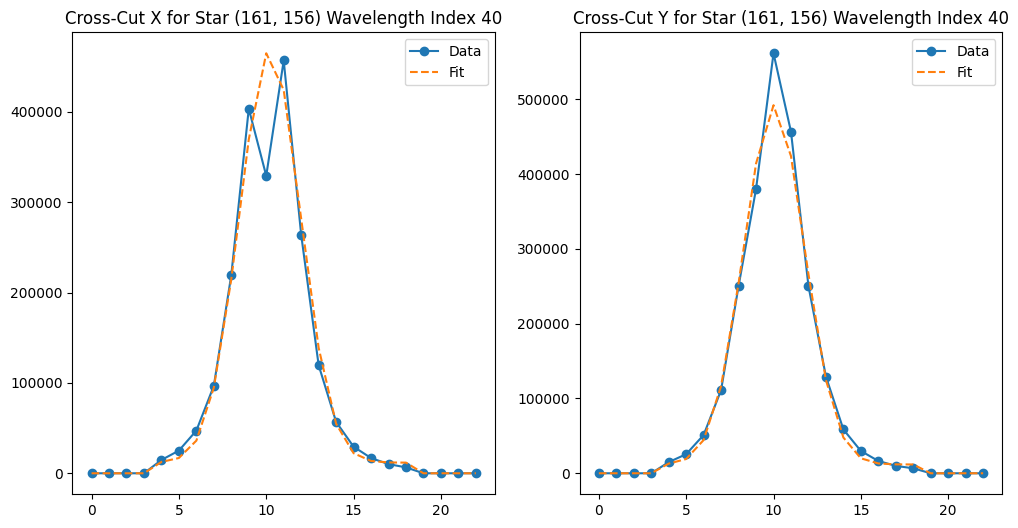

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3073.403564453125
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5158.43846
    reduced chi-square = 23.4474476
    Akaike info crit   = 714.764977
    Bayesian info crit = 731.845479
[[Variables]]
    x0:      6.17670058 +/- 0.02189706 (0.35%) (init = 6)
    y0:      6.02700776 +/- 0.02189706 (0.36%) (init = 6)
    sigma:   1.72725318 +/- 0.01730233 (1.00%) (init = 1)
    height:  542283.000 +/- 6874.55866 (1.27%) (init = 657321.8)
    offset:  12041.3739 +/- 1214.45572 (10.09%) (init = 16242.62)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6325
    C(sigma, offset) = -0.4463
{'x0': 6.176700582247812, 'y0': 6.027007760887478, 'sigma': 1.7272531755430394, 'height': 542282.999877975, 'offset': 12041.373881384492}
Chi-squared: 5158.4384629

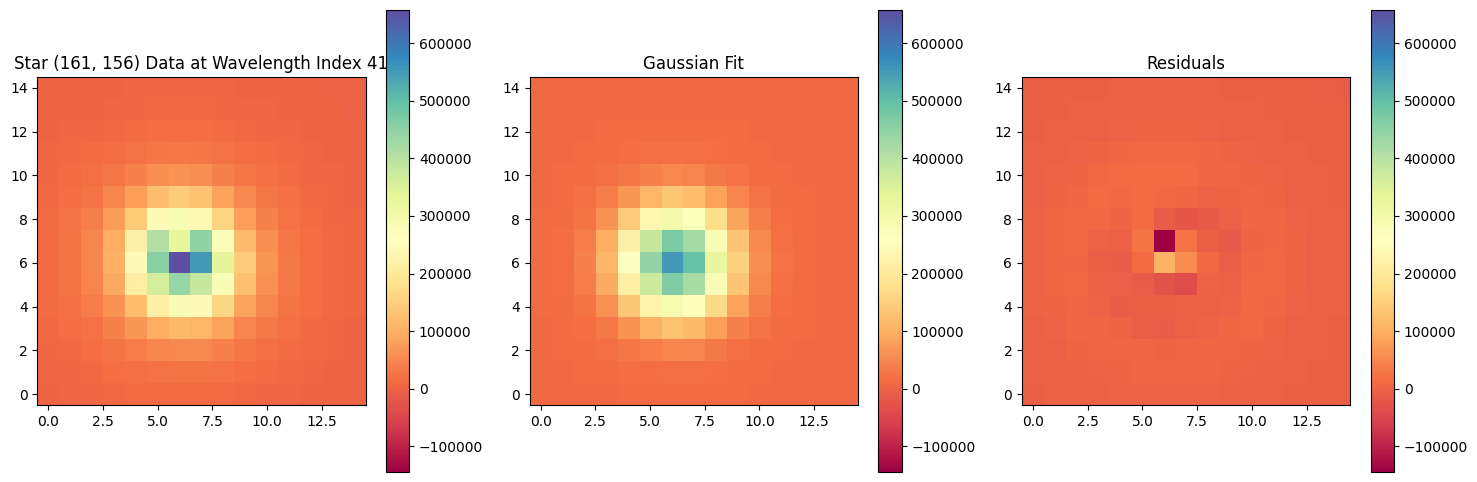

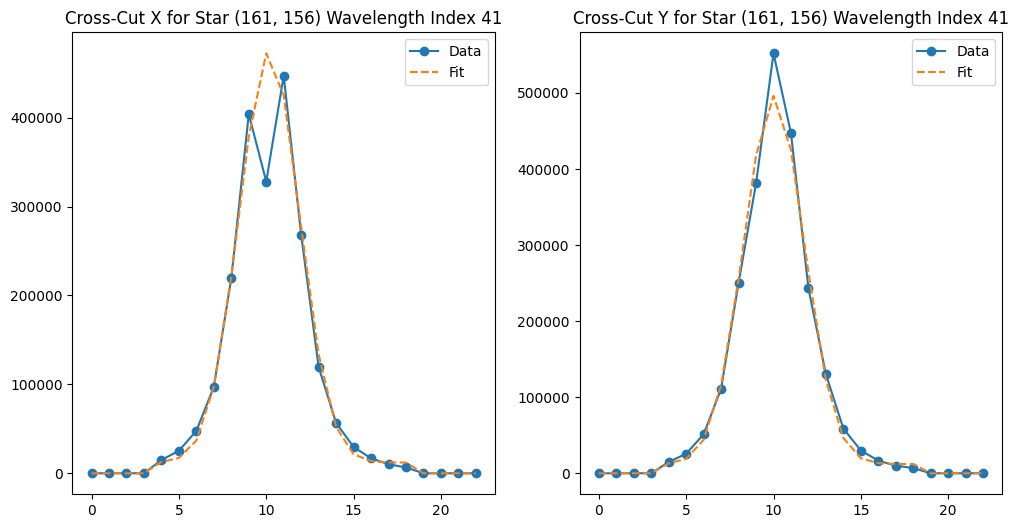

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3145.619384765625
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 225
    # variables        = 5
    chi-square         = 5652.38244
    reduced chi-square = 25.6926475
    Akaike info crit   = 735.339701
    Bayesian info crit = 752.420203
[[Variables]]
    x0:      6.20820302 +/- 0.02396761 (0.39%) (init = 6)
    y0:      6.02894322 +/- 0.02396761 (0.40%) (init = 6)
    sigma:   1.73971530 +/- 0.01897891 (1.09%) (init = 1)
    height:  530800.448 +/- 7312.48201 (1.38%) (init = 662526.9)
    offset:  12084.0194 +/- 1305.81367 (10.81%) (init = 16709.41)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, height) = -0.6311
    C(sigma, offset) = -0.4501
{'x0': 6.2082030230330325, 'y0': 6.028943216441827, 'sigma': 1.7397152971397776, 'height': 530800.4481297144, 'offset': 12084.019402744758}
Chi-squared: 5652.38244

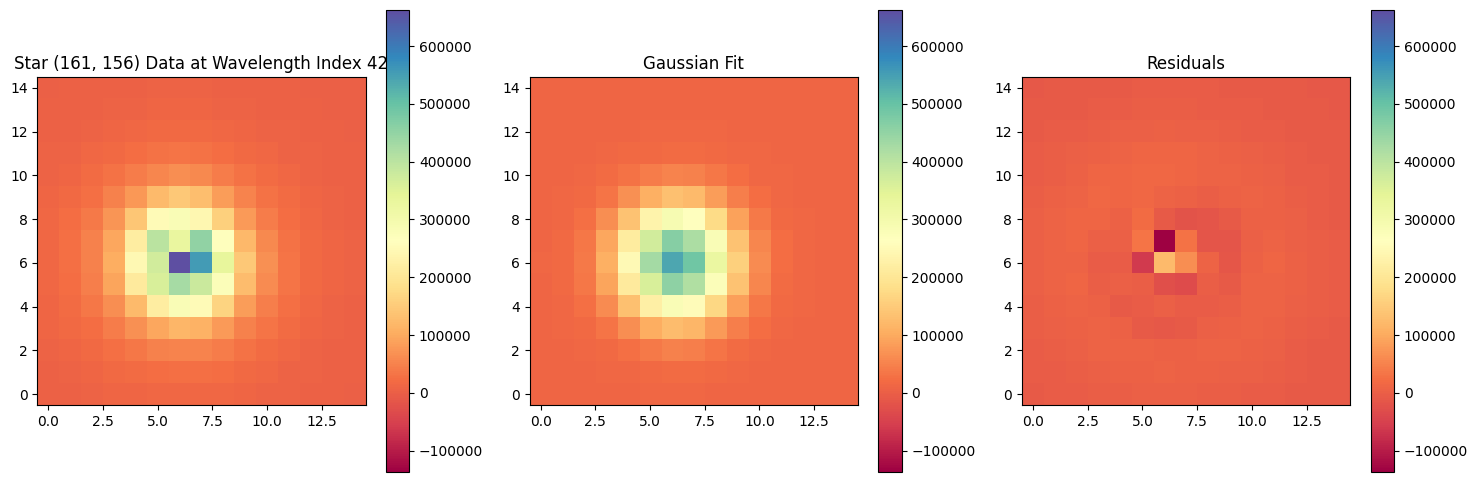

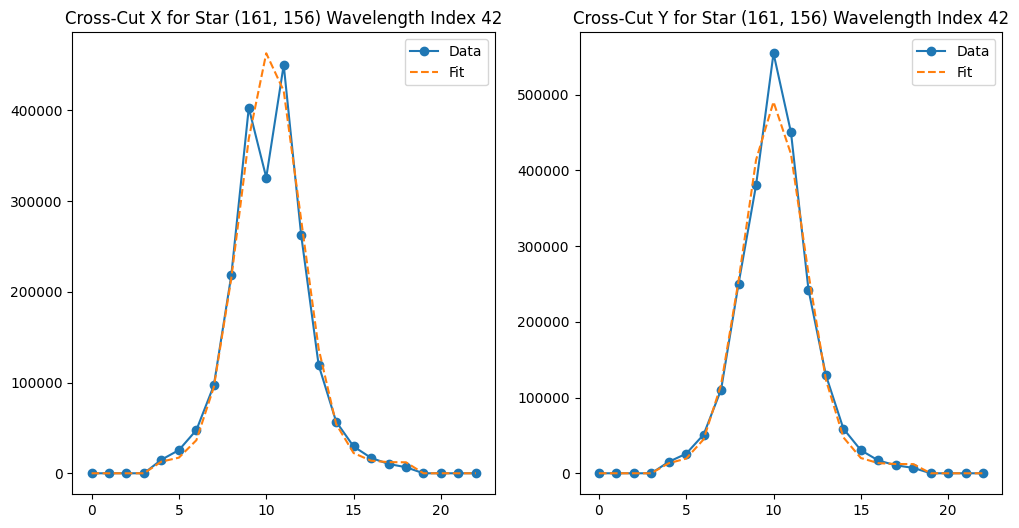

Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3140.03369140625
Error processing star (161, 156) at wavelength index 43: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.
Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3087.292724609375
Error processing star (161, 156) at wavelength index 44: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.
Data shape: (3681, 319, 318)
Uncertainties shape: (3681, 319, 318)
Estimated noise standard deviation: 3048.872314453125
Error processing star (161

In [101]:
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    if file.tell() == 0:
        writer.writerow(['Star_ID', 'Wavelength_Index', 'x0', 'y0', 'sigma', 'height', 'offset', 'chi_squared', 'reduced_chi_squared', 'r_squared'])

    for star_id, x0, y0 in stars:
        for wavelength_index in wavelength_indices:
            try:
                image_data, uncertainties = load_muse_data(filename, wavelength_index)
                
                sub_image = image_data[y0-7:y0+8, x0-7:x0+8]
                sub_uncertainties = uncertainties[y0-7:y0+8, x0-7:x0+8]

                noise_region = np.concatenate((
                    sub_image[:3, :3].flatten(),  # Top-left corner
                    sub_image[:3, -3:].flatten(),  # Top-right corner
                    sub_image[-3:, :3].flatten(),  # Bottom-left corner
                    sub_image[-3:, -3:].flatten()  # Bottom-right corner
                ))
                noise_std = np.std(noise_region)
                print(f"Estimated noise standard deviation: {noise_std}")
                
                snr = sub_image / noise_std

                x = np.linspace(0, 14, 15)
                y = np.linspace(0, 14, 15)
                X, Y = np.meshgrid(x, y)

                initial_x0 = np.argmax(np.sum(sub_image, axis=0))
                initial_y0 = np.argmax(np.sum(sub_image, axis=1))
                initial_height = sub_image[initial_y0, initial_x0]
                initial_offset = np.median(sub_image)

                params = Parameters()
                params.add('x0', value=initial_x0)
                params.add('y0', value=initial_y0)
                params.add('sigma', value=1)
                params.add('height', value=initial_height)
                params.add('offset', value=initial_offset)

                minner = Minimizer(residual, params, fcn_args=(X, Y, sub_image, noise_std))
                result = minner.minimize()

                report_fit(result)

                fit = result.params.valuesdict()
                print(fit)

                model = gaussian_2d(X, Y, fit['x0'], fit['y0'], fit['sigma'], fit['height'], fit['offset'])
                residuals, chi_squared, reduced_chi_squared, r_squared = calculate_goodness_of_fit(sub_image, model, noise_std)
                
                print(f"Chi-squared: {chi_squared}")
                print(f"Reduced Chi-squared: {reduced_chi_squared}")
                print(f"R-squared: {r_squared}")

                writer.writerow([star_id, wavelength_index, fit['x0'], fit['y0'], fit['sigma'], fit['height'], fit['offset'], chi_squared, reduced_chi_squared, r_squared])

                
                plot_fit_results(sub_image, model, residuals, star_id, wavelength_index)
                plot_cross_cuts(sub_image, model, star_id, wavelength_index)

            except Exception as e:
                print(f"Error processing star {star_id} at wavelength index {wavelength_index}: {e}")

In [71]:
import pandas as pd

# Define the file path
csv_file_path = 'star_fit_results.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Display the entire contents of the CSV file
df


Star_ID  Wavelength_Index         x0        y0      sigma       height  \
0  (119, 171)              1490  24.904651 -3.032897  10.679851  9282.731959   
1  (119, 171)               206   6.131593  6.097182   1.379447  2571.892946   

       offset  chi_squared  reduced_chi_squared  r_squared  
0  563.637886    12.811640             0.058501   0.858894  
1  387.495558    96.057303             0.438618   0.803556

In [72]:
# Define the file path
csv_file_path = 'star_fit_results.csv'

# Open the file in write mode to truncate its contents
with open(csv_file_path, mode='w', newline='') as file:
    # Optionally, write the header if you want to start fresh
    writer = csv.writer(file)
    writer.writerow(['Star_ID', 'Wavelength_Index', 'x0', 'y0', 'sigma', 'height', 'offset'])

print("File contents deleted.")

File contents deleted.
